In [3]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material/EURECA_scripts')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import *

import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.
perc_step = 5

In [6]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [7]:
# import sea_mask
# if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
#     sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
    sea_mask_modified_nan = np.ones_like(sea_mask_modified)
    sea_mask_modified_nan[sea_mask_modified==0] = np.nan
    
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')    
    
tourbillons_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/tourbillons_mask.npy')
open_ocean_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/open_ocean_mask.npy')

In [2]:
def non_nan_number(array):
    return np.sum(~np.isnan(array))

def clear_of_nans(array):
    return array[~np.isnan(array)]

# this part is to compute qcloudpercell

In [7]:

GPH_base = xr.open_dataset(wrf_files[files_ls.index('PHB.nc')])
GPH_base = GPH_base['PHB']/9.81

GPH = xr.open_dataset(wrf_files[files_ls.index('PH.nc')])
GPH = GPH['PH'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))/9.81


GPH = GPH_base + GPH
GPH = GPH.transpose('time_counter', 'lev_W', 'y_grid_M', 'x_grid_M')
# GPH = GPH.where(sea_mask_modified, drop=False)

del GPH_base

In [ ]:
press_from_GPH = mpcalc.height_to_pressure_std(GPH*units.meters)
del GPH

In [9]:
my_save_data('/venus/tesi_ale/data_EU/PRES/press_from_GPH_allDom.npy', [press_from_GPH])

creating new file and saving variables


In [7]:
press_from_GPH = np.load('/venus/tesi_ale/data_EU/PRES/press_from_GPH.npy')

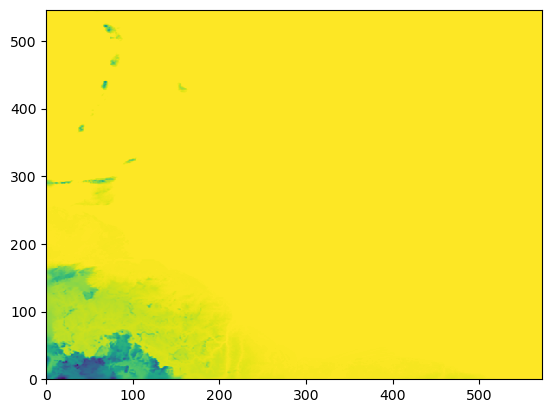

In [9]:
plt.pcolormesh(press_from_GPH[0,10])

In [ ]:
QCLOUD = xr.open_dataset(wrf_files[files_ls.index('QCLOUD.nc')])
dx, dy = QCLOUD.attrs['DX'], QCLOUD.attrs['DY']
QCLOUD = QCLOUD['QCLOUD'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000')).groupby('time_counter.day').mean()
# QCLOUD = QCLOUD.where(sea_mask_modified, drop=False)

In [8]:
press_diff = np.zeros((232,39,546,573))  #(QCLOUD.values)
press_diff = press_from_GPH[:,0:-1,:,:] - press_from_GPH[:,1:,:,:] 
del press_from_GPH

In [9]:
my_save_data('/venus/tesi_ale/data_EU/PRES/press_diff_allDom.npy', [press_diff])

file already exists - DELETING IT and creating it anew


In [ ]:
press_diff = np.load('/venus/tesi_ale/data_EU/PRES/press_diff_allDom.npy')

In [12]:
qcloud_percell = (QCLOUD.values*1000.)*press_diff/9.81
del press_diff

In [12]:
non_nan_number(qcloud_percell.values)/(8*39)

5113512.0

In [14]:
qcloud_percell.name='qcloud_percell'
qcloud_percell.attrs['long_name'] = 'WHOLE COMPUTATIONAL DOMAIN. Grams of liquid cloud water in every gridbox; I used GPH-derived pressure'
qcloud_percell.attrs['units'] = 'g/m2'

In [7]:
###   RETRIEVE TOTAL PRESSURE 

pres_base = xr.open_dataset(wrf_files[files_ls.index('PB.nc')])
pres_base = pres_base['PB']

pres = xr.open_dataset(wrf_files[files_ls.index('P.nc')])
pres = pres['P'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))


pres = (pres+pres_base)/100.                # hectoPascals
# pres = pres.where(sea_mask_modified, drop=False)

del pres_base

In [16]:
######  ALREADY CHANGED FROM 800 TO 850

LWP_lowTropo = qcloud_percell.where(pres>=850.).sum(dim='lev_M')  #*sea_mask_modified_nan


In [17]:
LWP_total = qcloud_percell.sum(dim='lev_M')

In [21]:
non_nan_number(LWP_total.values)/(8)

5113512.0

In [18]:
LWP_total.name = 'LWP_total'
LWP_total.attrs['long_name'] = 'WHOLE COMPUTATIONAL DOMAIN. Column integrated QCLOUD (in grams per m2), total height'
LWP_total.attrs['units'] = 'g/m2'


LWP_lowTropo.name = 'LWP_lowTropo'
LWP_lowTropo.attrs['long_name'] = 'WHOLE COMPUTATIONAL DOMAIN. Column integrated QCLOUD (in grams per m2) below 800hPa'
LWP_lowTropo.attrs['units'] = 'grams/m2'

In [19]:
ds_out = xr.Dataset()
ds_out = ds_out.assign(qcloud_percell=qcloud_percell)
ds_out = ds_out.assign(LWP_total=LWP_total)
ds_out = ds_out.assign(LWP_lowTropo=LWP_lowTropo)

In [20]:
ds_out.to_netcdf('/venus/tesi_ale/data_EU/QCLOUD/hourly/FEB/NEWNEW_qcloud_gm2_percell_WHOLEDOM.nc')

# ### End of qcloudpercell computation

In [9]:
mean_qcloud_profile = np.nanmean(QCLOUD.values, axis=(0,2,3))

In [8]:
QCLOUD

<xarray.DataArray 'QCLOUD' (day: 29, lev_M: 39, y_grid_M: 546, x_grid_M: 573)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
    nav_lon_grid_M  (y_grid_M, x_grid_M) float32 ...
    nav_lat_grid_M  (y_grid_M, x_grid_M) float32 ...
  * lev_M           (lev_M) float32 1.0 2.0 3.0 4.0 5.0 ... 36.0 37.0 38.0 39.0
  * day             (day) int64 1 2 3 4 5 6 7 8 9 ... 21 22 23 24 25 26 27 28 29
Dimensions without coordinates: y_grid_M, x_grid_M

Text(0, 0.5, 'pressure [hPa]')

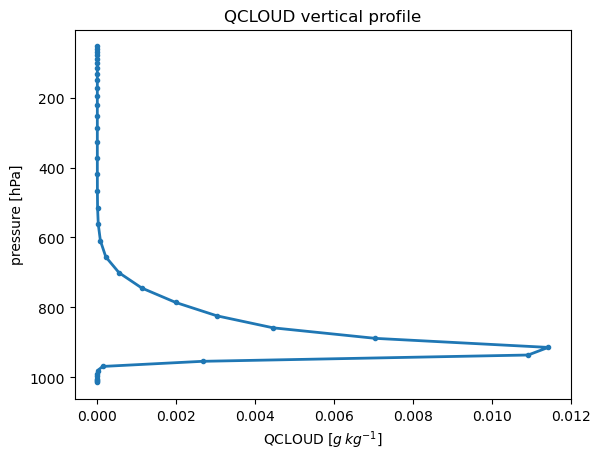

In [13]:
fig, ax = plt.subplots(1)

ax.plot(mean_qcloud_profile*1000, mean_vert_pres, '.-', linewidth=2)

ax.invert_yaxis()

ax.set_title('QCLOUD vertical profile')
ax.set_xlabel(r'QCLOUD [$g\,kg^{-1}$]')
ax.set_ylabel('pressure [hPa]')

## Maps for EMS Proceedings

In [7]:
ds_lwp = xr.open_dataset('/venus/tesi_ale/data_EU/QCLOUD/hourly/FEB/NEWNEW_qcloud_gm2_percell_WHOLEDOM.nc')
qcloud_pcell = ds_lwp['qcloud_percell']

In [8]:
###   RETRIEVE TOTAL PRESSURE 

pres_base = xr.open_dataset(wrf_files[files_ls.index('PB.nc')])
pres_base = pres_base['PB']

pres = xr.open_dataset(wrf_files[files_ls.index('P.nc')])
pres = pres['P'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))


pres = (pres+pres_base)/100.                # hectoPascals
# pres = pres.where(sea_mask_modified, drop=False)

del pres_base

In [9]:
LWP_lowTropo = qcloud_pcell.where(pres>=850.).sum(dim='lev_M')  #*sea_mask_modified_nan
LWP_lowTropo_day = LWP_lowTropo.groupby('time_counter.day').mean().values
# del pres

In [10]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

sst_day = ds_hourly['SST'].groupby('time_counter.day').mean()            
# sst_day = sst_day.where(sea_mask_modified, drop=False); 

lat, lon = sst_day['nav_lat'], sst_day['nav_lon']

In [15]:
s = 50   #100

dsst_day = np.zeros(sst_day.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    sst_ave = gm.nan_gaussian_filter(sst_day[t]*sea_mask_modified_nan,s)                             
    dsst_day[t] = sst_day[t]*sea_mask_modified_nan - sst_ave

0
10
20


In [11]:
s = 50   #100

dLWP_lowTropo_day, LWP_lowTropo_day_bar = np.zeros(LWP_lowTropo_day.shape), np.zeros(LWP_lowTropo_day.shape)

for t in range(0,LWP_lowTropo_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    LWP_lowTropo_day_bar[t] = gm.nan_gaussian_filter(LWP_lowTropo_day[t]*sea_mask_modified_nan,s)                             
    dLWP_lowTropo_day[t] = LWP_lowTropo_day[t]*sea_mask_modified_nan - LWP_lowTropo_day_bar[t]
    
    
mean_LWCC = np.nanmean(LWP_lowTropo_day*sea_mask_modified_nan, axis=(0,1,2))

# matte_CFC = dLWP_lowTropo_day / mean_LWCC
my_CFC = dLWP_lowTropo_day / LWP_lowTropo_day_bar

0
10
20


In [36]:
perc_step = 5
nbins = int(100/perc_step)

pdist_dsst, pdist_MyCFC, pstd_LWPlow_day, pstderr_LWPlow_day, pnpoints_LWPlow_day, ppvalue_LWPlow_day_sub = \
distrib_2d(dsst_day, my_CFC*100, perc_step, nbins, popmean, perc_fixbin = 'perc')

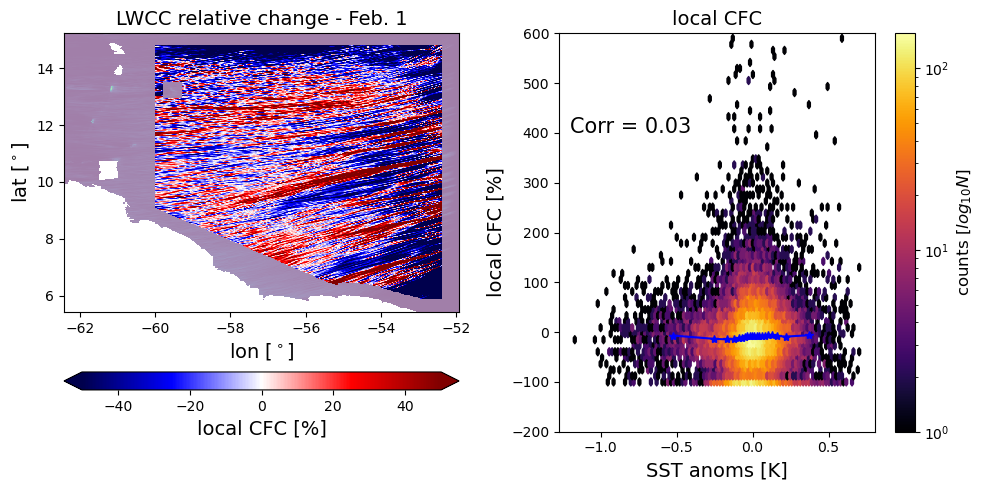

In [37]:
day = int(0)
fig, ax = plt.subplots(1,2,figsize=(10,5))

x = (LWP_lowTropo_day[day])*(sst_day[day]/sst_day[day])
mesh = ax[0].pcolormesh(lon, lat, x, cmap='viridis', alpha=0.5)
# cbar1 = plt.colorbar(mesh,ax=ax[0], extend='both', location='bottom')
# cbar1.set_label(label='SST [$^\circ$C]',fontsize=14)
# ticks = np.round(cbar1.get_ticks(), 0)
# cbar1.set_ticks(ticks)

# # Hatching land
# dhatch_land = np.zeros_like(sst_day[day])
# dhatch_land[np.isnan(sst_day[day]/sst_day[day])] = 1
# cont2 = ax[0].contourf(lon, lat, dhatch_land, levels=[0.9, 1.1], hatches=['//'], colors='none', alpha=0.05)

# # hatching mask
# dhatch_mask = np.zeros_like(sst_day[day])
# dhatch_mask[(1-sea_mask_modified)==1 & (dhatch_land==0)] = 1
# cont2 = ax[0].contourf(lon, lat, dhatch_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.05)


y = [dLWP_lowTropo_day[day]*sea_mask_modified_nan, my_CFC]
cbar_labs = ['LWCC anomalies [$g\,m^{-2}$]', 'local CFC [%]']

mesh_anoms = ax[0].pcolormesh(lon, lat, y[1][0]*100, vmin=-50, vmax=50, cmap='seismic')
cbar_anoms = plt.colorbar(mesh_anoms, ax=ax[0], location='bottom', extend='both')
cbar_anoms.set_label(cbar_labs[1], fontsize=14)
# cbar_anoms.set_ticks([-0.1, -0.05, 0, 0.05, 0.1])


ax[0].set_title("LWCC relative change - Feb."+f" {day+1}", fontsize=14)
ax[0].set_xlabel('lon [$^\circ$]', fontsize=14)
ax[0].set_ylabel('lat [$^\circ$]', fontsize=14)



########


x = dsst_day
y = my_CFC*100  #dLWP_lowTropo_day*sea_mask_modified_nan

fit, corcoe, p_value, p_value_cannelli, sigmas_anoms = slopes_r_p_mix(x, y, nt, nskip)
title= 'local CFC'  #"LWCC' low Troposphere - SST' "
xlabel='SST anoms [K]'
ylabel= 'local CFC [%]'   #r'LWCC anoms [$g\,m^{-2}$]'


fig = density_hexbin_subplots(x[::1, ::nskip, ::nskip],y[::1, ::nskip, ::nskip], fit=None,corcoe=None,grdsz=100, fig=fig, ax=ax[1],\
                              title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=[0.1,0.9])

ax[1].text(-1.2, 400, f'Corr = {round(corcoe,2)}', fontsize=15)
ax[1].set_ylim([-200, 600])






##############  adding percentiles  ################

ax[1].plot(pdist_dsst, pdist_MyCFC, '*-b' )


plt.tight_layout()



In [8]:
ds_lwp = xr.open_dataset('/venus/tesi_ale/data_EU/QCLOUD/hourly/FEB/NEWNEW_qcloud_gm2_percell_WHOLEDOM.nc')
LWP_lowTropo = ds_lwp['LWP_lowTropo']
LWP_lowTropo_day = LWP_lowTropo.groupby('time_counter.day').mean()



In [9]:
## preparing masks
complementary = 1-sea_mask_modified
complementary[complementary==0] == np.nan

array([False, False, False, ..., False, False, False])

In [16]:
lon.shape

(546, 573)

Text(0, 0.5, 'lat [$^\\circ$]')

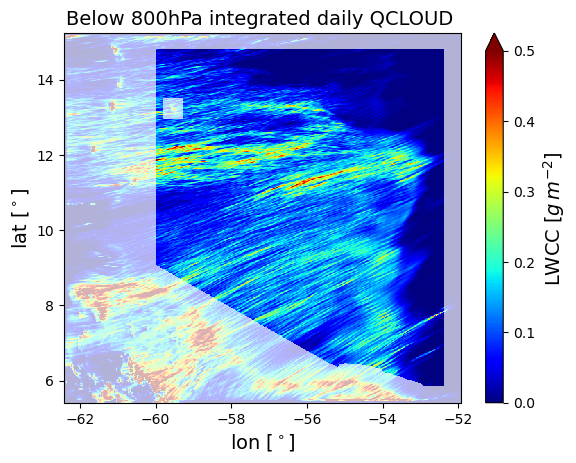

In [21]:
day = int(10)

plt.pcolormesh(lon , lat, (LWP_lowTropo_day.values[day]*complementary),vmin=0, vmax=0.5, cmap='jet', alpha=0.3)
plt.pcolormesh(lon, lat, (LWP_lowTropo_day.values[day]*sea_mask_modified_nan),vmin=0, vmax=0.5, cmap='jet')
cbar = plt.colorbar(extend='max')
cbar.set_label(label=r'LWCC [$g\,m^{-2}$]' , fontsize=14)

plt.title('Below 800hPa integrated daily QCLOUD ', fontsize=14)
plt.xlabel(r'lon [$^\circ$]', fontsize=14 )
plt.ylabel(r'lat [$^\circ$]', fontsize=14)


# plt.savefig('/venus/tesi_ale/img_EU/QCLOUD/map_LWPLow_total.png')

Text(0, 0.5, 'lat [$^\\circ$]')

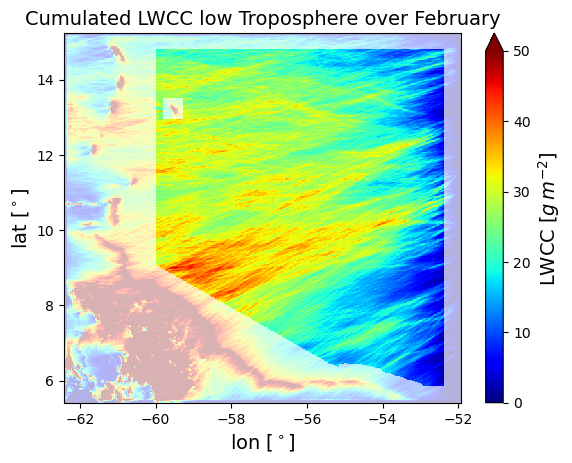

In [45]:
plt.pcolormesh(lon, lat, lwp_low_total_month.values*complementary, vmin=0, vmax=50, cmap='jet', alpha=0.3)
plt.pcolormesh(lon, lat, lwp_low_total_month.values*sea_mask_modified_nan, vmin=0, vmax=50, cmap='jet')
cbar = plt.colorbar(extend='max')
cbar.set_label(label=r'LWCC [$g\,m^{-2}$]' , fontsize=14)

plt.title('Cumulated LWCC low Troposphere over February', fontsize=14)
plt.xlabel(r'lon [$^\circ$]', fontsize=14 )
plt.ylabel(r'lat [$^\circ$]', fontsize=14)


# plt.savefig('/venus/tesi_ale/img_EU/QCLOUD/map_LWPLow_total.png')

In [37]:
lwp_total_month = LWP_total.sum(dim='time_counter')

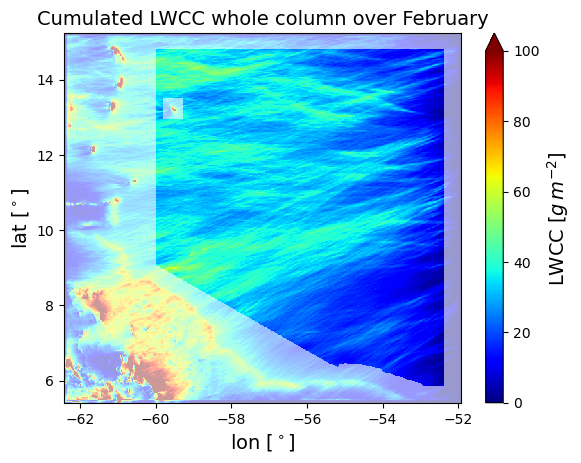

In [40]:
plt.pcolormesh(lon, lat, lwp_total_month.values*complementary, vmin=0, vmax=100, cmap='jet', alpha=0.4)
plt.pcolormesh(lon, lat, lwp_total_month.values*sea_mask_modified_nan, vmin=0, vmax=100, cmap='jet')
cbar = plt.colorbar(extend='max')
cbar.set_label(label=r'LWCC [$g\,m^{-2}$]' , fontsize=14)

plt.title('Cumulated LWCC whole column over February', fontsize=14)
plt.xlabel(r'lon [$^\circ$]', fontsize=14 )
plt.ylabel(r'lat [$^\circ$]', fontsize=14)


# plt.savefig('/venus/tesi_ale/img_EU/QCLOUD/map_LWPTot_total.png')

In [24]:
np.nanpercentile(LWP_lowTropo.values*sea_mask_modified_nan, 99)

0.983768105506897

### assess cloudiness frequency

In [8]:
ds_lwp = xr.open_dataset('/venus/tesi_ale/data_EU/QCLOUD/hourly/FEB/NEWNEW_qcloud_gm2_percell_WHOLEDOM.nc')
LWP_lowTropo = ds_lwp['LWP_lowTropo']
LWP_lowTropo_day = LWP_lowTropo.groupby('time_counter.day').mean()

In [25]:
LWP_lowTropo_mean_mean = ds_lwp['LWP_lowTropo'].mean(dim='time_counter').values

In [13]:
LWP_lowTropo_std = ds_lwp['LWP_lowTropo'].std(dim='time_counter')
LWP_lowTropo_day_std = LWP_lowTropo_day.std(dim='day')

In [14]:
LWP_lowTropo_mean = ds_lwp['LWP_lowTropo'].mean(dim='time_counter')
LWP_lowTropo_day_mean = LWP_lowTropo_day.mean(dim='day')

Text(0, 0.5, 'lat [$^\\circ$]')

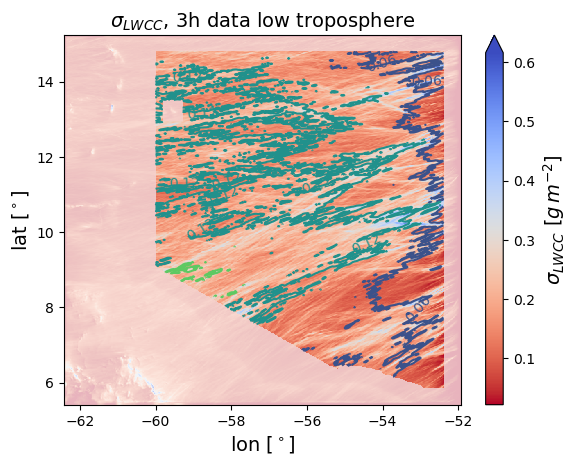

In [35]:
plt.pcolormesh(lon, lat, LWP_lowTropo_std.values*complementary,  cmap='coolwarm_r', alpha=0.3)  #vmin=0., vmax=0.25,
plt.pcolormesh(lon, lat, LWP_lowTropo_std.values*sea_mask_modified_nan, cmap='coolwarm_r')  #  vmin=0., vmax=0.25,
cbar = plt.colorbar(extend='max')
cbar.set_label(label=r'$\sigma_{LWCC}$ [$g\,m^{-2}$]' , fontsize=14)

# pres_conts = plt.contour(lon, lat, LWP_lowTropo_mean_mean*sea_mask_modified_nan, levels=3, cmap='viridis')
# plt.clabel(pres_conts, inline=True, fontsize=10)

plt.title("$\sigma_{LWCC}$, 3h data low troposphere", fontsize=14)
plt.xlabel(r'lon [$^\circ$]', fontsize=14 )
plt.ylabel(r'lat [$^\circ$]', fontsize=14)


# plt.savefig('/venus/tesi_ale/img_EU/QCLOUD/map_sigma_LWCC_LowTropo_3h.png')

In [106]:
dsst_5 = np.nanpercentile(dsst.values, 5)
dsst_95 = np.nanpercentile(dsst.values, 95)

dsst_5_day = np.nanpercentile(dsst_day.values, 5)
dsst_95_day = np.nanpercentile(dsst_day.values, 95)

LWP_low_50 = np.nanpercentile(LWP_lowTropo.values*sea_mask_modified_nan, 50)
LWP_low_50_day = np.nanpercentile(LWP_lowTropo_day.values*sea_mask_modified_nan, 50)
# LWP_low_95 = np.nanpercentile(LWP_lowTropo.values*sea_mask_modified_nan, 95)
# LWP_low_95_day = np.nanpercentile(LWP_lowTropo_day.values*sea_mask_modified_nan, 95)


mask_cold = np.where(dsst.values < dsst_5, 1, 0)
mask_cold_day = np.where(dsst_day.values < dsst_5_day, 1, 0)

frequency_cold = np.sum(LWP_lowTropo*mask_cold > LWP_low_50, axis=0)*100/232
mask_frequency_cold = np.where(frequency_cold>0, 1, np.nan)
frequency_cold_day = np.sum(LWP_lowTropo_day*mask_cold_day > LWP_low_50_day, axis=0)*100/232
mask_frequency_cold_day = np.where(frequency_cold_day>0, 1, np.nan)



mask_warm = np.where(dsst.values > dsst_95, 1, 0)
mask_warm_day = np.where(dsst_day.values > dsst_95_day, 1, 0)

frequency_warm = np.sum(LWP_lowTropo*mask_warm > LWP_low_50, axis=0)*100/232
mask_frequency_warm = np.where(frequency_warm>0, 1, np.nan)
frequency_warm_day = np.sum(LWP_lowTropo_day*mask_warm_day > LWP_low_50_day, axis=0)*100/232
mask_frequency_warm_day = np.where(frequency_warm_day>0, 1, np.nan)

Text(0, 0.5, 'lat [$^\\circ$]')

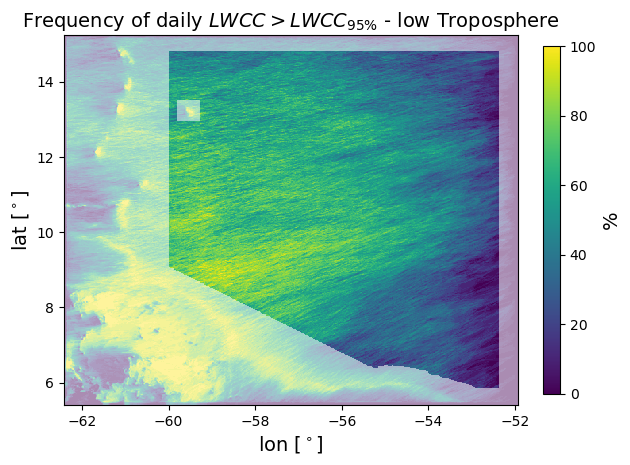

In [107]:
frequency_day = np.sum(LWP_lowTropo_day > LWP_low_50_day, axis=0)*100/29

plt.pcolormesh(lon, lat, frequency_day*complementary, alpha=0.45)
plt.pcolormesh(lon, lat,frequency_day*sea_mask_modified_nan)

cbar = plt.colorbar(fraction=0.035)
cbar.set_label(label=r'%' , fontsize=14)

plt.title(r'Frequency of daily $LWCC > LWCC_{95\%}$ - low Troposphere', fontsize=14)
plt.xlabel(r'lon [$^\circ$]', fontsize=14 )
plt.ylabel(r'lat [$^\circ$]', fontsize=14)


# plt.savefig('/venus/tesi_ale/img_EU/QCLOUD/map_LWPLow_DayFrequency_95.png')

Text(0, 0.5, 'lat [$^\\circ$]')

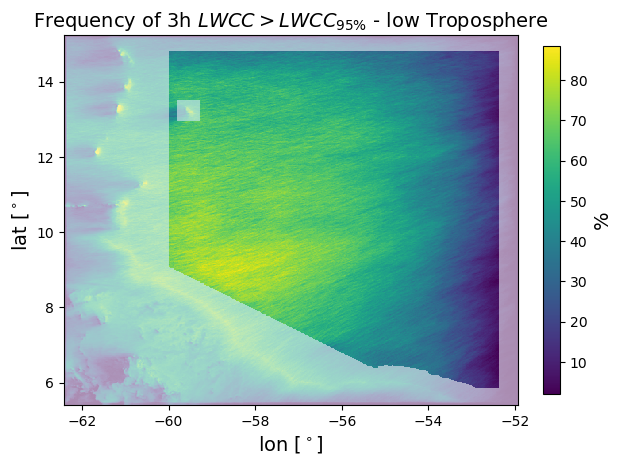

In [108]:
frequency = np.sum(LWP_lowTropo > LWP_low_50, axis=0)*100/232

plt.pcolormesh(lon, lat, frequency*complementary, alpha=0.45)
plt.pcolormesh(lon, lat,frequency*sea_mask_modified_nan)

cbar = plt.colorbar(fraction=0.035)
cbar.set_label(label=r'%' , fontsize=14)

plt.title(r'Frequency of 3h $LWCC > LWCC_{95\%}$ - low Troposphere', fontsize=14)
plt.xlabel(r'lon [$^\circ$]', fontsize=14 )
plt.ylabel(r'lat [$^\circ$]', fontsize=14)


# plt.savefig('/venus/tesi_ale/img_EU/QCLOUD/map_LWPLowFrequency_3h_95.png')

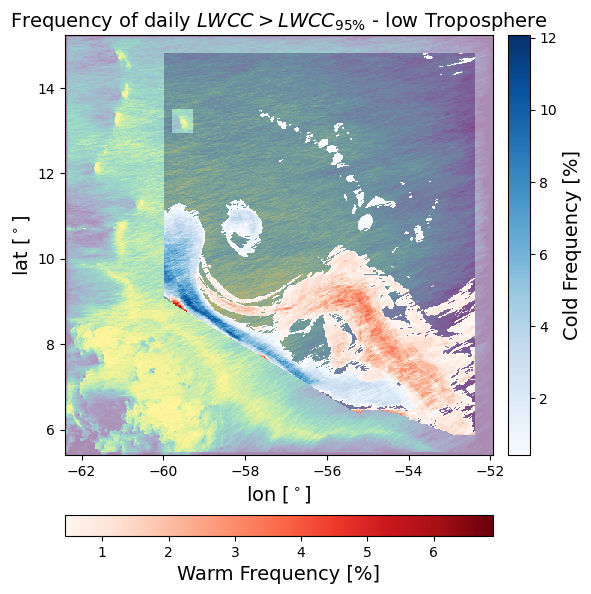

In [109]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6,6.5))

ax.pcolormesh(lon, lat, frequency_day*complementary, alpha=0.45)
ax.pcolormesh(lon, lat, frequency_day*sea_mask_modified_nan, alpha=0.45)


# Plot cold and warm data using pcolormesh
cold = ax.pcolormesh(lon, lat, frequency_cold_day * mask_frequency_cold_day, cmap='Blues')
warm = ax.pcolormesh(lon, lat, frequency_warm_day * mask_frequency_warm_day, cmap='Reds')

# Create a divider for the existing axes instance to make space for colorbars
divider = make_axes_locatable(ax)

# Create axes for the cold colorbar to the right of the plot
cax_cold = divider.append_axes("right", size="5%", pad=0.15)
cbar_cold = plt.colorbar(cold, cax=cax_cold, fraction=0.015)
cbar_cold.set_label('Cold Frequency [%]', fontsize=14)

# Create axes for the warm colorbar at the bottom of the plot
cax_warm = divider.append_axes("bottom", size="5%", pad=0.6)  # Position it at the bottom
cbar_warm = plt.colorbar(warm, cax=cax_warm, orientation='horizontal', fraction=0.015)
cbar_warm.set_label('Warm Frequency [%]',  fontsize=14)


ax.set_title(r'Frequency of daily $LWCC > LWCC_{95\%}$ - low Troposphere', fontsize=14)
ax.set_xlabel(r'lon [$^\circ$]', fontsize=14 )
ax.set_ylabel(r'lat [$^\circ$]', fontsize=14)


# plt.savefig('/venus/tesi_ale/img_EU/QCLOUD/map_LWPLowFrequency_day_95_WarmCold.png')

plt.show()


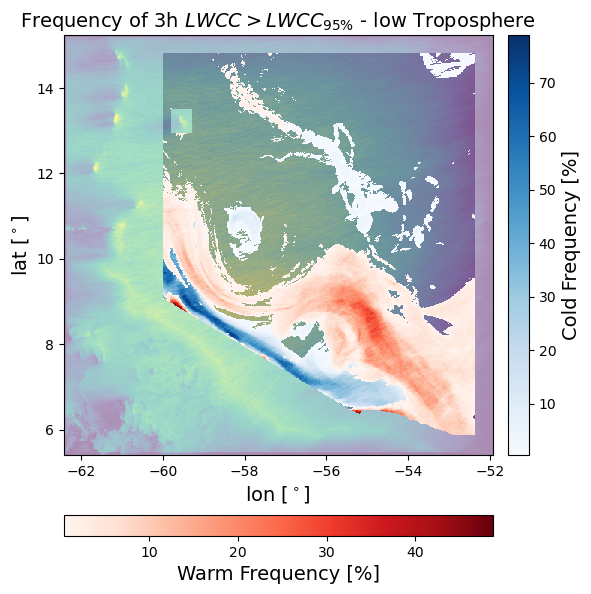

In [110]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6,6.5))

ax.pcolormesh(lon, lat, frequency*complementary, alpha=0.45)
ax.pcolormesh(lon, lat, frequency*sea_mask_modified_nan, alpha=0.45)


# Plot cold and warm data using pcolormesh
cold = ax.pcolormesh(lon, lat, frequency_cold * mask_frequency_cold, cmap='Blues')
warm = ax.pcolormesh(lon, lat, frequency_warm * mask_frequency_warm, cmap='Reds')

# Create a divider for the existing axes instance to make space for colorbars
divider = make_axes_locatable(ax)

# Create axes for the cold colorbar to the right of the plot
cax_cold = divider.append_axes("right", size="5%", pad=0.15)
cbar_cold = plt.colorbar(cold, cax=cax_cold, fraction=0.015)
cbar_cold.set_label('Cold Frequency [%]', fontsize=14)

# Create axes for the warm colorbar at the bottom of the plot
cax_warm = divider.append_axes("bottom", size="5%", pad=0.6)  # Position it at the bottom
cbar_warm = plt.colorbar(warm, cax=cax_warm, orientation='horizontal', fraction=0.015)
cbar_warm.set_label('Warm Frequency [%]',  fontsize=14)


ax.set_title(r'Frequency of 3h $LWCC > LWCC_{95\%}$ - low Troposphere', fontsize=14)
ax.set_xlabel(r'lon [$^\circ$]', fontsize=14 )
ax.set_ylabel(r'lat [$^\circ$]', fontsize=14)


# plt.savefig('/venus/tesi_ale/img_EU/QCLOUD/map_LWPLowFrequency_3h_95_WarmCold.png')

plt.show()


## Assess distributions as function of SST and surface fluxes

In [10]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))


In [11]:
sst_day = ds_hourly['SST'].groupby('time_counter.day').mean()            
sst_day = sst_day.where(sea_mask_modified, drop=False); 

lat, lon = sst_day['nav_lat'], sst_day['nav_lon']

In [8]:
s = 100   #100

dsst_day = np.zeros(sst_day.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    sst_ave = gm.nan_gaussian_filter(sst_day[t],s)                             
    dsst_day[t] = sst_day[t] - sst_ave

0
10
20


#### this is to load high-passed data at 200km that I used for the thesis

In [12]:
ds_qcloud = xr.open_dataset('/venus/tesi_ale/data_EU/QCLOUD/hourly/FEB/NEW_qcloud_gm2_percell.nc')
# qcloud_percell = ds_qcloud['qcloud_percell']
LWP_lowTropo = ds_qcloud['LWP_lowTropo']
LWP_total = ds_qcloud['LWP_total']

# Daily statistics --> using daily anomalies of SST

In [12]:
qc_percell_day = qcloud_percell.groupby('time_counter.day').mean()*sea_mask_modified_nan

In [8]:
LWP_lowTropo_day = LWP_lowTropo.groupby('time_counter.day').mean()*sea_mask_modified_nan
LWP_total_day = LWP_total.groupby('time_counter.day').mean()*sea_mask_modified_nan

#### updating mixing ratio plots , 21st sept

In [14]:
## compute anomalies for qcloud_percell
s = 100
dqc = np.zeros(QCLOUD.shape)

for t in range(0,QCLOUD.shape[0]):
    if t % 10 == 0:
        print(t)
    
    for h in range(0,QCLOUD.shape[1]):
        q_ave = gm.nan_gaussian_filter(QCLOUD[t,h].values,s)                            
        dqc[t,h] = QCLOUD[t,h].values - q_ave

0
10
20
30
40
50
60
70
80


KeyboardInterrupt: 

In [11]:
perc_step = 2;  nbins=int(100/perc_step)

pdist_dsst, pdist_qc, pstd_qc, pstderr_qc, pnpoints_qc, ppvalue_qc_sub = \
dist_3d_subsample(dsst_day, QCLOUD.values, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')



0
10
20
30


In [10]:
perc_step = 2;  nbins=int(100/perc_step)

pdist_dsst, pdist_dqc, pstd_dqc, pstderr_dqc, pnpoints_dqc, ppvalue_dqc_sub = \
dist_3d_subsample(dsst_day, dqc, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')


0
10
20
30


In [70]:
xr_pdist_dsst = xr.DataArray(pdist_dsst, dims=['dsst'], name='pdist_dsst'); 
xr_pdist_dsst.attrs['long_name'] = '5% percentiles of dsst with latest mask'

xr_pdist_qc = xr.DataArray(pdist_qc, dims=['pressure', 'dsst'], name='pdist_qc')
xr_pdist_qc.attrs['long_name'] = '5% percentiles of qcloud_percell (g/m2) with latest mask'

xr_pstd_qc = xr.DataArray(pstd_qc, dims=['pressure', 'dsst'], name='pstd_qc')
xr_pstd_qc.attrs['long_name'] = 'resulting qc_percell std dev per percentile bin'

xr_pstderr_qc = xr.DataArray(pstderr_qc, dims=['pressure', 'dsst'], name='pstderr_qc')
xr_pstderr_qc.attrs['long_name'] = 'resulting qc_percell stderr per percentile bin'

xr_pnpoints_qc = xr.DataArray(pnpoints_qc, dims=['pressure', 'dsst'], name='pnpoints_qc')
xr_pnpoints_qc.attrs['long_name'] = 'number of points in every bin'

xr_ppvalue_qc_sub = xr.DataArray(ppvalue_qc_sub, dims=['pressure', 'dsst'], name='ppvalue_qc_sub')
xr_ppvalue_qc_sub.attrs['long_name'] = 'computed pvalues'


# If you want to put them in a dataset
dataset = xr.Dataset({
    'pdist_dsst': xr_pdist_dsst,
    'pdist_qc': xr_pdist_qc,
    'pstd_qc': xr_pstd_qc,
    'pstderr_qc': xr_pstderr_qc,
    'pnpoints_qc': xr_pnpoints_qc,
    'ppvalue_qc_sub': xr_ppvalue_qc_sub
})

In [72]:
# dataset.to_netcdf(path='/venus/tesi_ale/data_EU/QCLOUD/daily/FEB/NEW_pdistrs_qcloud_percell_daily_NEW.nc')

In [45]:
pdistrs_qcloud_percell_daily = xr.open_dataset('/venus/tesi_ale/data_EU/QCLOUD/daily/FEB/NEW_pdistrs_qcloud_percell_daily_NEW.nc')

pdist_dsst = pdistrs_qcloud_percell_daily['pdist_dsst']
pdist_qc = pdistrs_qcloud_percell_daily['pdist_qc']
pstd_qc = pdistrs_qcloud_percell_daily['pstd_qc']

NEED TO LOAD SOME MORE DATA FOR PLOTTING:
   - PBLH_pr distributions
   - mean_vert_pres

In [ ]:
PBLH_day = ds_hourly['PBLH'].groupby('time_counter.day').mean()
PBLH_day = PBLH_day.where(sea_mask_modified, drop=False).values;

# PBLH IN PRESSURE VALUES! 
# output is in hPa
PBLH_pres = mpcalc.height_to_pressure_std(PBLH_day*units.meters)
PBLH_pres = PBLH_pres.magnitude #.m_as('hPa')

In [ ]:
# DISTRIBUTION PBLH vs dSST bin - DAILY 
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

#  PBLH distrib

# perc
pdist_dsst, pdist_PBLH_dsst, pstd_PBLH_dsst, pstderr_PBLH_dsst, pnpoints_PBLH_dsst, ppvalue_PBLH_dsst = \
distrib_2d(dsst_day, PBLH_pres, perc_step, nbins, popmean, perc_fixbin = 'perc')


# pdist_sst, pdist_PBLH_sst, pstd_PBLH_sst, pstderr_PBLH_sst, pnpoints_PBLH_sst, ppvalue_PBLH_sst = \
# distrib_2d(sst_day.values, PBLH_pres, perc_step, nbins, popmean, perc_fixbin = 'perc')


## add LCL to the plots!

In [ ]:
ds_lcl = xr.open_dataset('/venus/tesi_ale/data_EU/LCL/daily/FEB/LCL_feb.nc')
LCL_day = ds_lcl['LCL_day'].values*sea_mask_modified_nan

LCL_pres = mpcalc.height_to_pressure_std(LCL_day*units.meters)
LCL_pres = LCL_pres.magnitude #.m_as('hPa')

In [23]:
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

#  LCL distrib

# perc
pdist_dsst, pdist_LCL_dsst, pstd_LCL_dsst, pstderr_LCL_dsst, pnpoints_LCL_dsst, ppvalue_LCL_dsst = \
distrib_2d(dsst_day, LCL_pres, perc_step, nbins, popmean, perc_fixbin = 'perc')


# pdist_sst, pdist_LCL_sst, pstd_LCL_sst, pstderr_LCL_sst, pnpoints_LCL_sst, ppvalue_LCL_sst = \
# distrib_2d(sst_day.values, LCL_pres, perc_step, nbins, popmean, perc_fixbin = 'perc')

In [18]:
### LOAD PRESSURE COLUMN
mean_vert_pres = np.load('/venus/tesi_ale/data_EU/PRES/daily/FEB/mean_vert_pres.npy')

# distrs = xr.open_dataset('/venus/tesi_ale/data_EU/PBLH/daily/FEB/pdistrs_PBLHpr_dsst_day_feb.nc')
# PBLH = distrs['pdist_PBLHpr_dsst'].values


/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/NEW_pdist_dsst_qcloud_lowTropo_withLCL_MR.png


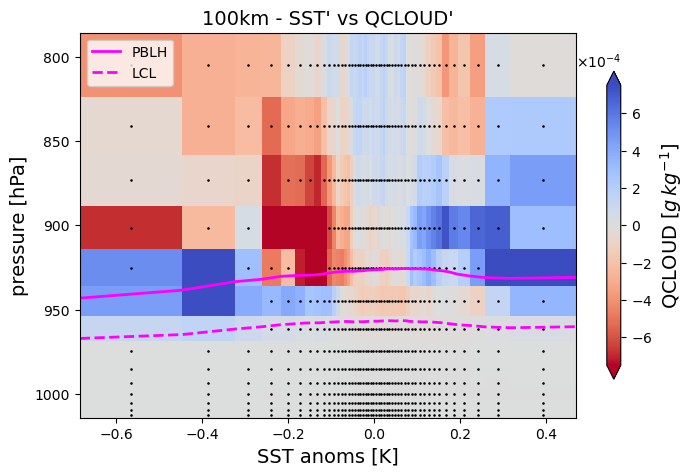

In [34]:
fig, ax1 = plt.subplots(figsize=(8, 5)) 
ax1.invert_yaxis()

p_level_plot = int(15)
anoms = True

title = "100km - SST' vs QCLOUD'" 
x = pdist_dsst 
var = pdist_dqc*1000 
minval = -0.75e-3; maxval = -minval

 

p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var[0:p_level_plot], cmap='coolwarm_r', vmin=minval, vmax=maxval)
ax1.set_xlabel('SST anoms [K]', fontsize=14)
ax1.set_ylabel('pressure [hPa]', fontsize=14)
ax1.set_title(f"{title}", fontsize=14)

cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label(r'QCLOUD [$g\,kg^{-1}$]', fontsize=14)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.update_ticks()

var_pbl = pdist_PBLH_dsst  
ax1.plot(x, var_pbl, '-', color='magenta', linewidth=2, label='PBLH')
# ax1.text(0.35, 945, 'PBLH', fontsize=13, color='r')

var_lcl = pdist_LCL_dsst  
ax1.plot(x, var_lcl, '--', color='magenta', linewidth=2, label='LCL')
ax1.legend()
# ax1.text(0.35, 975, 'LCL', fontsize=12, color='r')




# DEF punti significativi (pvalue < 0.05)
if anoms:
    pval = ppvalue_dqc_sub[0:p_level_plot] #if perc else pvalue_dQVAPOR_day_sub[0:p_level_plot]
    GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
    
    signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
    dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
    
    for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
        cond1 = pval[h,:-1] > 0.05
        cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
        cond = (cond1) | (cond2)
    #     cond = cond1
        signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
        signif_Lcorr_H[h, cond] = GPbin[h]
        dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')

    pval = ppvalue_dqc_sub[0:p_level_plot]
    where_not_sig = np.where(pval>0.05, 1, np.nan)
    xx = np.zeros_like(var)
    for i in range(xx.shape[0]):
        xx[i,:] = x
    
# plt.scatter(xx[0:p_level_plot].flatten(),(var[0:p_level_plot]*where_not_sig[0:p_level_plot]).flatten(),  s=0.7, color='k')
# plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')






# savefig
path_img = '/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/' 
filename = path_img + 'NEW_pdist_dsst_qcloud_lowTropo_withLCL_MR.png'
# plt.savefig(filename)
print(filename)
del filename

## Sections as function of surface fluxes

In [ ]:
LHF = ds_hourly['LH'].groupby('time_counter.day').mean()
LHF = LHF.where(sea_mask_modified, drop=False).values*sea_mask_modified_nan; 

HFX = ds_hourly['HFX'].groupby('time_counter.day').mean()            
HFX = HFX.where(sea_mask_modified, drop=False).values*sea_mask_modified_nan; 


T2_day = ds_hourly['T2'].groupby('time_counter.day').mean()
T2_day = T2_day.where(sea_mask_modified, drop=False).values*sea_mask_modified_nan
buoya = sst_day - T2_day

In [ ]:
s = 100

dLHF, dHFX = np.zeros(LHF.shape), np.zeros(HFX.shape)
dBuoya = np.zeros(buoya.shape)

for t in range(0, LHF.shape[0]):
    if t % 10 == 0:
        print(t)
    
    lhf_ave = gm.nan_gaussian_filter(LHF[t], s)                             
    dLHF[t] = LHF[t] - lhf_ave
    
    hfx_ave = gm.nan_gaussian_filter(HFX[t], s)                             
    dHFX[t] = HFX[t] - hfx_ave
    
    b_ave = gm.nan_gaussian_filter(buoya[t], s)                             
    dBuoya[t] = buoya[t] - b_ave


In [ ]:
# PERC DISTRIBUTION dQCLOUD_fre vs dx 
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

which = int(3)
variabs = [dLHF, dHFX, buoya, dBuoya]
dx = variabs[which]

pdist_dx, pdist_dQCLOUD_dx, pstd_dQCLOUD_dx, pstderr_dQCLOUD_dx, pnpoints_dQCLOUD_dx, ppvalue_dQCLOUD_dx_sub = \
dist_3d_subsample(dx, dQCLOUD_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')


pdist_dx, pdist_PBLH, pstd_PBLH, pstderr_PBLH, pnpoints_PBLH, ppvalue_PBLH = \
distrib_2d(dx, PBLH_pres, perc_step, nbins, popmean, 'perc')

pdist_dx, pdist_LCL, pstd_LCL, pstderr_LCL, pnpoints_LCL, ppvalue_LCL = \
distrib_2d(dx, LCL_pres, perc_step, nbins, popmean, perc_fixbin = 'perc')

In [ ]:
# figure dBV or BV vs dSST bin - DAILY
p_level_plot = int(15)

# which = int(0)
# horizontal = [pdist_dLHF, pdist_dHFX, pdist_Buoy, pdist_dBuoy]
# vertical = [pdist_dBV_dLHF, pdist_dBV_dHFX, pdist_dBV_Buoy, pdist_dBV_dBuoy]

x = pdist_dx
var = pdist_dQVAPOR_dx[0:p_level_plot]*1e3
minval = -1.
maxval = -minval


###############   preparing plot   ###################
fig, ax1 = plt.subplots(figsize=(8, 5))  
ax1.invert_yaxis()

xlabs = ['LHF anoms [$W\,m^{-2}$]', 'SHF anoms [$W\,m^{-2}$]', 'SST - $T_{2m}$ [K]', "SST' - $T'_{2m}$ [K]"]
titles = [f" LHF' vs $q$'", f"  SHF' vs $q$'", " SST - $T_{2m}$ vs $q$'", " SST' - $T'_{2m}$ vs $q$'"]
ax1.set_xlabel(xlabs[which], fontsize=14);
ax1.set_ylabel('pressure [hPa]', fontsize=14)
plt.title(titles[which], fontsize=14)


###############   plotting and colorbar   ###################
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var, vmin=minval, vmax=maxval, cmap='seismic')

cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8,  pad=0.05)   # extend='both',
cbar.set_label('$q$ anoms [$g\,kg^{-1}$]', fontsize=15)
cbar.ax.tick_params(labelsize=14)



###############   plotting MABL   ###################
vertical_PBL = pdist_PBLH

x_pbl = x                         
var_pbl = vertical_PBL    #[which]    
ax1.plot(x_pbl, var_pbl, 'forestgreen', linewidth=2.5, label='MABLH')
ax1.legend(fontsize=14, loc='upper left')

ax1.tick_params(axis='x', labelsize=14) 
ax1.tick_params(axis='y', labelsize=14)



##################### DEF punti significativi (pvalue < 0.05)  ##############
# pvals_list = ppvalue_dQVAPOR_dx_sub #[ppvalue_dBV_dLHF_sub, ppvalue_dBV_dHFX_sub, ppvalue_dBV_Buoy_sub, ppvalue_dBV_dBuoy_sub]
pval = ppvalue_dQVAPOR_dx_sub[0:p_level_plot] #vals_list[which]
GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))

for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) | (cond2)
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')


# path_img = '/venus/tesi_ale/img_EU/BV/daily/FEB/' #if perc else '/venus/tesi_ale/img_EU/BV/daily/FEB/'
# filename = path_img + 'NEW_pdist_dsst_BV_lowtropo_openOcean.png' #if perc else path_img + 'bins_dsst_dBV_lowtropo.png'
# # plt.savefig(filename)
# print(filename)
# del filename

In [77]:
#######   THIS IS TO FIND THE VALUES OF dQVAPOR AT THE LEVEL CLOSEST TO PBLH    #######


where = np.zeros_like(pdist_PBLH_dsst)

for i in range(0, len(pdist_PBLH_dsst)):
    dist = np.abs(mean_vert_pres - pdist_PBLH_dsst[i])
    min_dist = np.min(dist)
    where[i] = np.argwhere(dist==min_dist).astype(int)

qc_at_pblh = np.zeros_like(pdist_dsst)
stderr_at_pblh = np.zeros_like(pdist_dsst)
std_at_pblh = np.zeros_like(pdist_dsst)

for i in range(0, len(pdist_dsst)):
    qc_at_pblh[i] = pdist_qc[int(where[i]), i]
    stderr_at_pblh[i] = pstderr_qc[int(where[i]), i]
    std_at_pblh[i] = pstd_qc[int(where[i]), i]


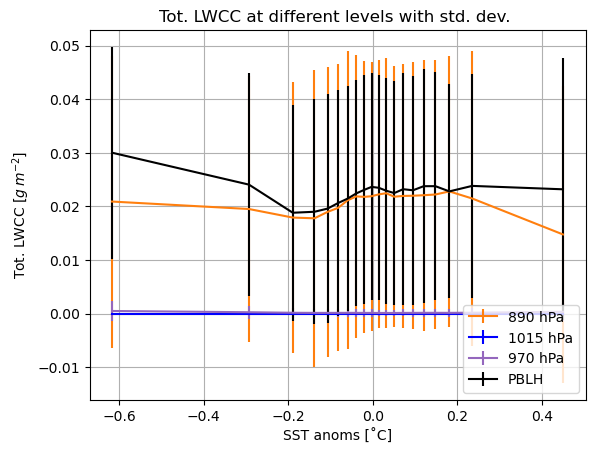

In [78]:
###  QVAPOR SCATTER AT DIFFERENT ALTITUDES  
plt.errorbar(pdist_dsst, pdist_qc[11,:], yerr=pstd_qc[11,:], xerr=None,\
             label='890 hPa', ecolor='#ff7f0e', linestyle='-', color='#ff7f0e')

plt.errorbar(pdist_dsst, pdist_qc[0,:], yerr=pstd_qc[0,:], xerr=None,\
             label='1015 hPa', ecolor='b', linestyle='-', color='b')

plt.errorbar(pdist_dsst, pdist_qc[7,:], yerr=pstd_qc[7,:], xerr=None,\
             label='970 hPa', ecolor='#9467bd', linestyle='-', color='#9467bd')

plt.errorbar(pdist_dsst, qc_at_pblh, yerr=std_at_pblh, xerr=None,\
             label='PBLH', ecolor='k', linestyle='-', color='k')


# plt.errorbar(pdist_dsst, pdist_qc[13,:]*1000, yerr=pstd_qc[13,:]*1000, xerr=None,\
#              label='825 hPa', ecolor='k', linestyle='-', color='k')

# plt.plot(pdist_dsst, qvapor_at_pblh*1000, '.-k', label='PBLH nrst')


# colors = {
#     'Forced HP': '#1f77b4',    # Blue
#     'Forced BP': '#ff7f0e',    # Orange
#     'Coupled HP': '#9467bd',   # Purple
#     'Coupled BP': '#17becf',   # Cyan
# }





plt.legend(loc='lower right')

plt.ylabel(r'Tot. LWCC [$g \, m^{-2}$]')
plt.xlabel('SST anoms [˚C]')
plt.title('Tot. LWCC at different levels with std. dev. ')
plt.grid()

# plt.savefig('/venus/tesi_ale/img_EU/QVAPOR_correct/daily/FEB/NEW_dqMoisture_levels_2%_withPBLH.png')



#########    WHY NEGATIVE VALUESS??

### spatial anomalies for qc and LWPs

In [56]:
## compute anomalies for qcloud_percell
s = 100
dqc_percell_day = np.zeros(qc_percell_day.shape)

for t in range(0,qc_percell_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    for h in range(0,qc_percell_day.shape[1]):
        q_ave = gm.nan_gaussian_filter(qc_percell_day[t,h],s)                            
        dqc_percell_day[t,h] = qc_percell_day[t,h] - q_ave

0
10
20


In [12]:
s = 100
dLWP_lowTropo_day = np.zeros(LWP_lowTropo_day.shape)
dLWP_total_day = np.zeros(LWP_total_day.shape)


for t in range(0,LWP_lowTropo_day.shape[0]):
    if t % 10 == 0:
        print(t)
        
    LWP_lowave = gm.nan_gaussian_filter(LWP_lowTropo_day[t],s)                            
    dLWP_lowTropo_day[t] = LWP_lowTropo_day[t] - LWP_lowave

    LWP_totave = gm.nan_gaussian_filter(LWP_total_day[t],s)                            
    dLWP_total_day[t] = LWP_total_day[t] - LWP_totave

0
10
20


In [48]:
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

# mask = tourbillons_mask  #  open_ocean_mask


# ### LOW TROPO  TOURBILLL
# pdist_sst, pdist_LWPLow, pstd_LWPLow, pstderr_LWPLow, pnpoints_LWPLow, ppvalue_LWPLow = \
# distrib_2d(sst_day.values*tourbillons_mask, LWP_lowTropo_day.values*tourbillons_mask, perc_step, nbins, popmean, perc_fixbin = 'perc')

# pdist_dsst, pdist_LWPLow_dsst, pstd_LWPLow_dsst, pstderr_LWPLow_dsst, pnpoints_LWPLow_dsst, ppvalue_LWPLow_dsst = \
# distrib_2d(dsst_day.values*tourbillons_mask, LWP_lowTropo_day.values*tourbillons_mask, perc_step, nbins, popmean, perc_fixbin = 'perc')

# pdist_dsst, pdist_dLWPLow, pstd_dLWPLow, pstderr_dLWPLow, pnpoints_dLWPLow, ppvalue_dLWPLow = \
# distrib_2d(dsst_day.values*tourbillons_mask, dLWP_lowTropo_day*tourbillons_mask, perc_step, nbins, popmean, perc_fixbin = 'perc')


# #### LOWTROPO OPEN OCEAN
# pdist_sst_OO, pdist_LWPLow_OO, pstd_LWPLow_OO, pstderr_LWPLow_OO, pnpoints_LWPLow_OO, ppvalue_LWPLow_OO = \
# distrib_2d(sst_day.values*open_ocean_mask, LWP_lowTropo_day.values*open_ocean_mask, perc_step, nbins, popmean, perc_fixbin = 'perc')

# pdist_dsst_OO, pdist_LWPLow_dsst_OO, pstd_LWPLow_dsst_OO, pstderr_LWPLow_dsst_OO, pnpoints_LWPLow_dsst_OO, ppvalue_LWPLow_dsst_OO = \
# distrib_2d(dsst_day.values*open_ocean_mask, LWP_lowTropo_day.values*open_ocean_mask, perc_step, nbins, popmean, perc_fixbin = 'perc')

# pdist_dsst_OO, pdist_dLWPLow_OO, pstd_dLWPLow_OO, pstderr_dLWPLow_OO, pnpoints_dLWPLow_OO, ppvalue_dLWPLow_OO = \
# distrib_2d(dsst_day.values*open_ocean_mask, dLWP_lowTropo_day*open_ocean_mask, perc_step, nbins, popmean, perc_fixbin = 'perc')




'''### TOTAL
pdist_sst, pdist_LWPTot, pstd_LWPTot, pstderr_LWPTot, pnpoints_LWPTot, ppvalue_LWPTot = \
distrib_2d(sst_day.values*mask, LWP_total_day.values*mask, perc_step, nbins, popmean, perc_fixbin = 'perc')

pdist_dsst, pdist_LWPTot_dsst, pstd_LWPTot_dsst, pstderr_LWPTot_dsst, pnpoints_LWPTot_dsst, ppvalue_LWPTot_dsst = \
distrib_2d(sst_day.values*mask, LWP_total_day.values*mask, perc_step, nbins, popmean, perc_fixbin = 'perc')

pdist_dsst, pdist_dLWPTot, pstd_dLWPTot, pstderr_dLWPTot, pnpoints_dLWPTot, ppvalue_dLWPTot = \
distrib_2d(dsst_day.values*mask, dLWP_total_day*mask, perc_step, nbins, popmean, perc_fixbin = 'perc')'''

"### TOTAL\npdist_sst, pdist_LWPTot, pstd_LWPTot, pstderr_LWPTot, pnpoints_LWPTot, ppvalue_LWPTot = distrib_2d(sst_day.values*mask, LWP_total_day.values*mask, perc_step, nbins, popmean, perc_fixbin = 'perc')\n\npdist_dsst, pdist_LWPTot_dsst, pstd_LWPTot_dsst, pstderr_LWPTot_dsst, pnpoints_LWPTot_dsst, ppvalue_LWPTot_dsst = distrib_2d(sst_day.values*mask, LWP_total_day.values*mask, perc_step, nbins, popmean, perc_fixbin = 'perc')\n\npdist_dsst, pdist_dLWPTot, pstd_dLWPTot, pstderr_dLWPTot, pnpoints_dLWPTot, ppvalue_dLWPTot = distrib_2d(dsst_day.values*mask, dLWP_total_day*mask, perc_step, nbins, popmean, perc_fixbin = 'perc')"

### comparing percentiles over the two subregions

/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/percentiles_dsst_LWPlowTropo_feb.png


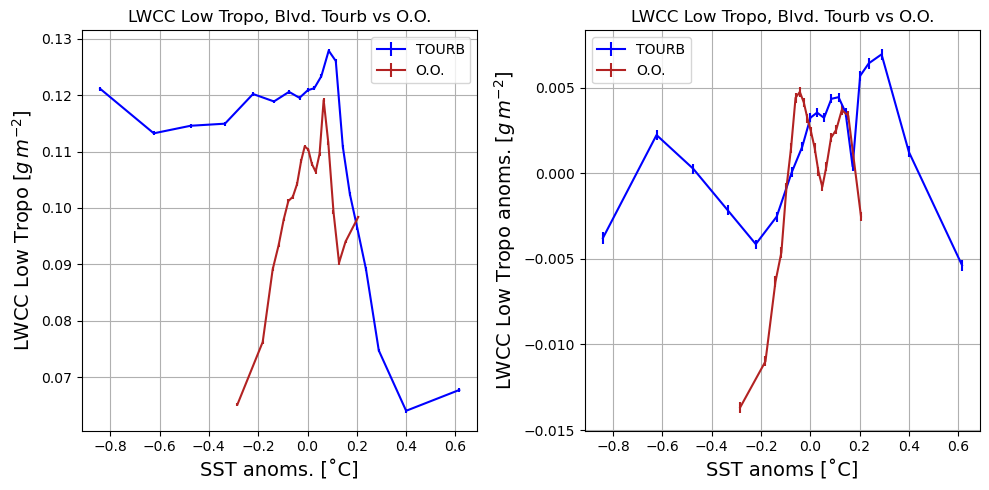

In [73]:
###### Figure


fig, (ax1, ax) = plt.subplots(1,2, figsize=(10,5))


# ax1.plot(pdist_sst-273.15, pdist_LWPLow, '.-',color='b', label='TOURB')
# ax1.plot(pdist_sst-273.15, pdist_LWPLow_OO, '.-',color='firebrick', label='O.O.')


ax1.errorbar(pdist_dsst, pdist_LWPLow, yerr=pstderr_LWPLow, xerr=None,\
            label='TOURB', ecolor='b', linestyle='-', color='b')
ax1.errorbar(pdist_dsst_OO, pdist_LWPLow_OO, yerr=pstderr_LWPLow_OO, xerr=None,\
            label='O.O.', ecolor='firebrick', linestyle='-', color='firebrick')
ax1.legend()

ax1.set_ylabel(r'LWCC Low Tropo [$g\,m^{-2}$]', fontsize=14); 
ax1.set_xlabel('SST anoms. [˚C]', fontsize=14); 
ax1.grid(); ax1.set_title('LWCC Low Tropo, Blvd. Tourb vs O.O.')



# ax.plot(pdist_dsst, pdist_dLWPLow, '.-',color='b', label='TOURB')
# ax.plot(pdist_dsst, pdist_dLWPLow_OO, '.-',color='firebrick', label='O.O.')
ax.errorbar(pdist_dsst, pdist_dLWPLow, yerr=pstderr_dLWPLow, xerr=None,\
            label='TOURB', ecolor='b', linestyle='-', color='b')
ax.errorbar(pdist_dsst_OO, pdist_dLWPLow_OO, yerr=pstderr_dLWPLow_OO, xerr=None,\
            label='O.O.', ecolor='firebrick', linestyle='-', color='firebrick')


ax.legend()

ax.set_ylabel('LWCC Low Tropo anoms. [$g\,m^{-2}$]', fontsize=14);
ax.set_xlabel('SST anoms [˚C]', fontsize=14); 
ax.grid(); ax.set_title('LWCC Low Tropo, Blvd. Tourb vs O.O.')

plt.tight_layout()



path_img = '/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/' 
filename = path_img + 'percentiles_dsst_LWPlowTropo_feb.png' #if dsst else path_img + 'scatter_sst_LWPlowTropo_feb.png'
# plt.savefig(filename)
print(filename)
del filename


/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/scatter_dsst_dLWPlowTropo_feb.png


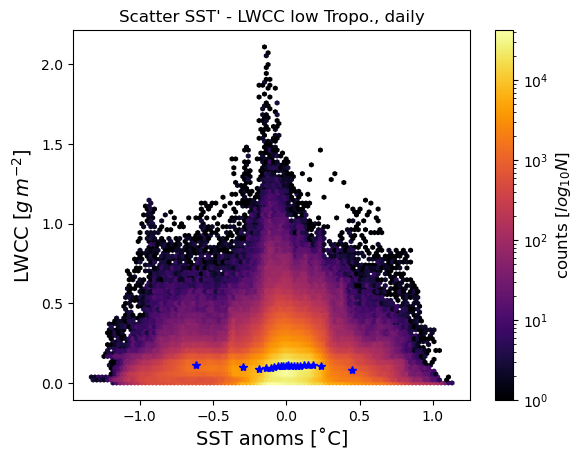

In [50]:
## LOWTROPO

dsst = True

if not dsst:
    x =  (sst_day-273.15).values
    y =  LWP_lowTropo_day.values 
    fit, corcoe, p_value, p_value_cannelli, sigmas_full = slopes_r_p_mix(x, y, nt, nskip)
    title=' Scatter SST - LWCC low Tropo., daily'
    xlabel='SST [˚C]'
    ylabel=r'LWCC [$g\,m^{-2}$]'
    
    xx = pdist_sst-273.15
    yy = pdist_LWPLow
    
else:
    x = dsst_day.values
    y = LWP_lowTropo_day.values
    
    fit, corcoe, p_value, p_value_cannelli, sigmas_anoms = slopes_r_p_mix(x, y, nt, nskip)
    title="Scatter SST' - LWCC low Tropo., daily"
    xlabel='SST anoms [˚C]'
    ylabel=r'LWCC [$g\,m^{-2}$]'
    
    xx = pdist_dsst
    yy = pdist_LWPLow_dsst
    

fig = density_hexbin(x,y,plot_fit=False,fit=None,corcoe=None,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=[0.1,0.9])
plt.plot(xx, yy, 'b*')

    
'''if p_value_cannelli < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')'''

    

path_img = '/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/' 
filename = path_img + 'scatter_dsst_dLWPlowTropo_feb.png' if dsst else path_img + 'scatter_sst_LWPlowTropo_feb.png'
# plt.savefig(filename)
print(filename)
del filename

/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/scatter_dsst_LWPlowTropo_feb.png


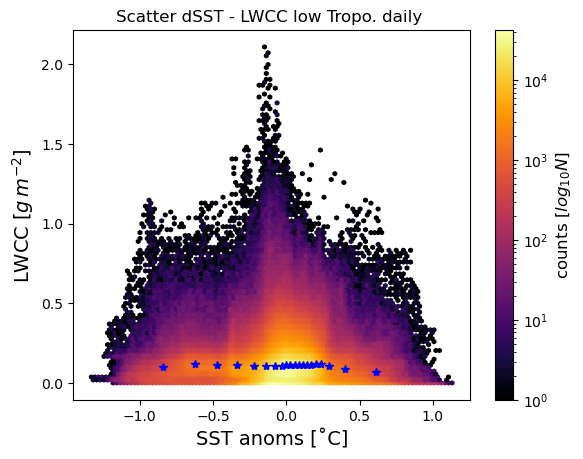

In [48]:
#### LOWTROPO - DSST


x = dsst_day.values
y = LWP_lowTropo_day.values

fit, corcoe, p_value, p_value_cannelli, sigmas_anoms = slopes_r_p_mix(x, y, nt, nskip)
title='Scatter dSST - LWCC low Tropo. daily '
xlabel='SST anoms [˚C]'
ylabel=r'LWCC [$g\,m^{-2}$]'

xx = pdist_dsst
yy = pdist_LWPLow_dsst
    

fig = density_hexbin(x,y,plot_fit=False,fit=None,corcoe=None,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=[0.1,0.9])
plt.plot(xx, yy, 'b*')

    
'''if p_value_cannelli < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')'''

    

path_img = '/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/' 
filename = path_img + 'scatter_dsst_LWPlowTropo_feb.png' #if dsst else path_img + 'scatterFIT_sst_RH_feb.png'
plt.savefig(filename)
print(filename)
del filename

/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/scatter_dsst_dLWPTotal_feb.png


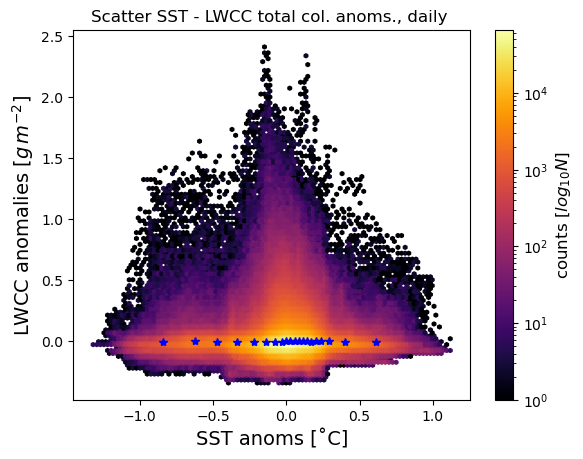

In [51]:
## LWCC TOTAL COLUMN 
## 

dsst = True

if not dsst:
    x =  (sst_day-273.15).values
    y =  LWP_total_day.values 
    fit, corcoe, p_value, p_value_cannelli, sigmas_full = slopes_r_p_mix(x, y, nt, nskip)
    title=' Scatter SST - LWCC total column, daily'
    xlabel='SST [˚C]'
    ylabel=r'LWCC [$g\,m^{-2}$]'
    
    xx = pdist_sst-273.15
    yy = pdist_LWPTot
    
else:
    x = dsst_day.values
    y = dLWP_total_day
    
    fit, corcoe, p_value, p_value_cannelli, sigmas_anoms = slopes_r_p_mix(x, y, nt, nskip)
    title='Scatter SST - LWCC total col. anoms., daily '
    xlabel='SST anoms [˚C]'
    ylabel=r'LWCC anomalies [$g\,m^{-2}$]'
    
    xx = pdist_dsst
    yy = pdist_dLWPTot
    

fig = density_hexbin(x,y,plot_fit=False,fit=None,corcoe=None,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=[0.1,0.9])
plt.plot(xx, yy, 'b*')

    
'''if p_value_cannelli < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')'''

    

path_img = '/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/' 
filename = path_img + 'scatter_dsst_dLWPTotal_feb.png' if dsst else path_img + 'scatter_sst_LWPTotal_feb.png'
# plt.savefig(filename)
print(filename)
del filename

/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/scatter_dsst_LWPTotal_feb.png


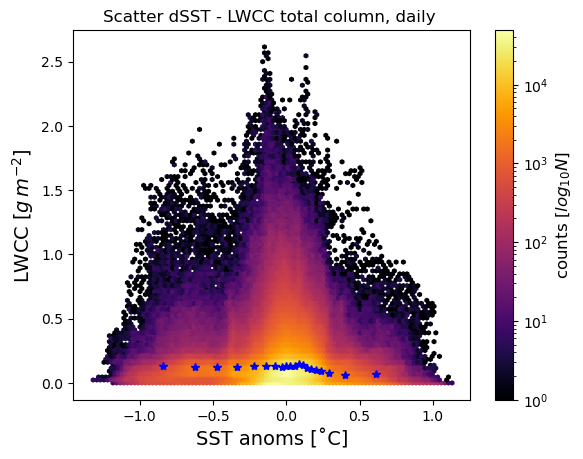

In [52]:
## LWCC TOTAL COLUMN - dsst


x = dsst_day.values
y = LWP_total_day.values

fit, corcoe, p_value, p_value_cannelli, sigmas_anoms = slopes_r_p_mix(x, y, nt, nskip)
title='Scatter dSST - LWCC total column, daily '
xlabel='SST anoms [˚C]'
ylabel=r'LWCC [$g\,m^{-2}$]'

xx = pdist_dsst
yy = pdist_LWPTot_dsst
    

fig = density_hexbin(x,y,plot_fit=False,fit=None,corcoe=None,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=[0.1,0.9])
plt.plot(xx, yy, 'b*')

    
'''if p_value_cannelli < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')'''

    

path_img = '/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/' 
filename = path_img + 'scatter_dsst_LWPTotal_feb.png' #if dsst else path_img + 'scatterFIT_sst_RH_feb.png'
plt.savefig(filename)
print(filename)
del filename

In [13]:
s = 100
dLWP_lowTropo = np.zeros(LWP_lowTropo.shape)

for t in range(0,LWP_lowTropo.shape[0]):
    if t % 20 == 0:
        print(t)
        
    LWP_lowave = gm.nan_gaussian_filter(LWP_lowTropo[t],s)                            
    dLWP_lowTropo[t] = LWP_lowTropo[t] - LWP_lowave

0
20
40
60
80
100
120
140
160
180
200
220


In [57]:
perc_step = 5;  nbins=int(100/perc_step)

pdist_dsst, pdist_dqc, pstd_dqc, pstderr_dqc, pnpoints_dqc, ppvalue_dqc_sub = \
dist_3d_subsample(dsst_day.values, dqc_percell_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')


0
10
20
30


In [24]:
## load data I need
distrs = xr.open_dataset('/venus/tesi_ale/data_EU/QCLOUD/daily/FEB/perc_dqcloud_percell_daily.nc')
pdist_dqc = distrs['pdist_dqc']
ppvalue_dqc_sub = distrs['ppvalue_dqc_sub']

/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/NEW_pdist_dsst_dqcloud.png


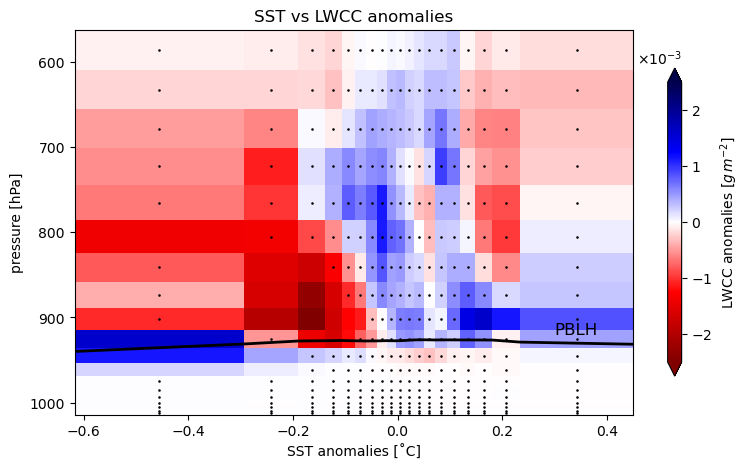

In [146]:

p_level_plot = int(20)


title = 'SST vs LWCC anomalies' #if perc else 'Fixed bins'
x = pdist_dsst #if perc else dist_dsst_day
var = pdist_dqc #if perc else dist_dQVAPOR_day
minval = -0.0025 ; maxval = -minval

fig, ax1 = plt.subplots(figsize=(9, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var[0:p_level_plot], vmin=minval, vmax=maxval, cmap='seismic_r')
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('pressure [hPa]')
plt.title(title)


cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label(r'LWCC anomalies [$g\,m^{-2}$]')
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.update_ticks()

var_pbl = pdist_PBLH_dsst  
ax1.plot(x, var_pbl, '-k', linewidth=2)
ax1.text(0.3, 920, 'PBLH', fontsize=12, color='k')



# DEF punti significativi (pvalue < 0.05)
pval = ppvalue_dqc_sub[0:p_level_plot]
GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')




# savefig
path_img = '/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/' 
filename = path_img + 'NEW_pdist_dsst_dqcloud.png'
# plt.savefig(filename)
print(filename)
del filename

In [65]:
xr_pdist_dsst = xr.DataArray(pdist_dsst, dims=['dsst'], name='pdist_dsst')
xr_pdist_dsst.attrs['long_name'] = '5% percentiles of dsst with latest mask'

xr_pdist_dqc = xr.DataArray(pdist_dqc, dims=['pressure', 'dsst'], name='pdist_dqc')
xr_pdist_dqc.attrs['long_name'] = '5% percentiles of dqc anomalies with latest mask'

xr_pstd_dqc = xr.DataArray(pstd_dqc, dims=['pressure', 'dsst'], name='pstd_dqc')
xr_pstd_dqc.attrs['long_name'] = 'resulting dqc anomalies std dev per percentile bin'

xr_pstderr_dqc = xr.DataArray(pstderr_dqc, dims=['pressure', 'dsst'], name='pstderr_dqc')
xr_pstderr_dqc.attrs['long_name'] = 'resulting dqc anomalies stderr per percentile bin'

xr_pnpoints_dqc = xr.DataArray(pnpoints_dqc, dims=['pressure', 'dsst'], name='pnpoints_dqc')
xr_pnpoints_dqc.attrs['long_name'] = 'number of points in every bin for dqc anomalies'

xr_ppvalue_dqc_sub = xr.DataArray(ppvalue_dqc_sub, dims=['pressure', 'dsst'], name='ppvalue_dqc_sub')
xr_ppvalue_dqc_sub.attrs['long_name'] = 'computed pvalues for dqc anomalies'

# Create a dataset to manage the arrays together
dataset_anomalies = xr.Dataset({
    'pdist_dsst': xr_pdist_dsst,
    'pdist_dqc': xr_pdist_dqc,
    'pstd_dqc': xr_pstd_dqc,
    'pstderr_dqc': xr_pstderr_dqc,
    'pnpoints_dqc': xr_pnpoints_dqc,
    'ppvalue_dqc_sub': xr_ppvalue_dqc_sub
})


dataset_anomalies.to_netcdf(path='/venus/tesi_ale/data_EU/QCLOUD/daily/FEB/perc_dqcloud_percell_daily.nc')

# Hourly statistics

In [78]:
dsst = xr.open_dataset('/venus/tesi_ale/data_EU/SST/hourly/FEB/dSST_feb.nc')
dsst = dsst['dSST'].where(sea_mask_modified, drop=False)
    
## DAILY
#dsst = dsst[::3,:,:]  #dsst.groupby('time_counter.day').mean()

# HOW MUCH OF TOTAL LWP IS DUE TO LOW TROPOSPHERIC LWP?

In [ ]:
#   distribution of LWP low tropo vs dsst 

In [83]:
#### DAY

perc_step = 5;  nbins=int(100/perc_step)

pdist_dsst_day, pdist_LWPlow_day, pstd_LWPlow_day, pstderr_LWPlow_day, pnpoints_LWPlow_day, ppvalue_LWPlow_day_sub = \
distrib_2d(dsst_day.values, LWP_lowTropo_day.values, perc_step, nbins, popmean, perc_fixbin = 'perc')


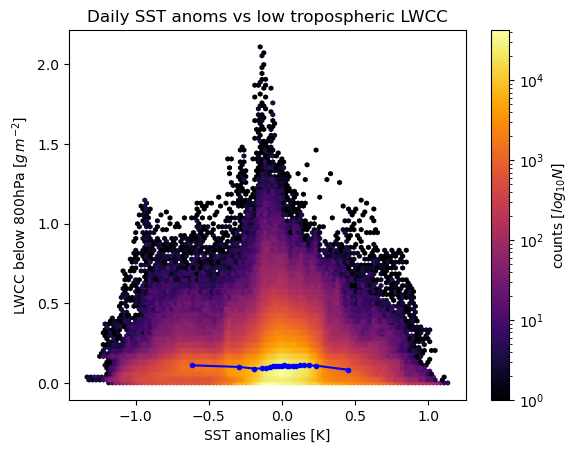

In [95]:
x = dsst_day.values
y = LWP_lowTropo_day.values
    
density_hexbin(x, y, plot_fit=False, fit=None, corcoe=None, grdsz=100, \
                        title=r'Daily SST anoms vs low tropospheric LWCC', xlabel='SST anomalies [K]', ylabel='LWCC below 800hPa [$g\,m^{-2}$]', colormap='inferno', pos=pos)

plt.plot(pdist_dsst_day, pdist_LWPlow_day, '.-b')

# plt.savefig('/venus/tesi_ale/img_EU/QCLOUD/hourly/FEB/scatter_dsst_LWCCLow_daily.png')

In [94]:
pdist_LWPlow

array([0.1080338 , 0.10071701, 0.08934028, 0.09016042, 0.0921902 ,
       0.0953821 , 0.10095851, 0.10500759, 0.10677705, 0.10817959,
       0.10975868, 0.11017619, 0.10910028, 0.10959895, 0.10788577,
       0.10958122, 0.11024911, 0.11243499, 0.11190984, 0.08677498])

In [93]:
pdist_LWPlow_day

array([0.11061187, 0.10045019, 0.09008778, 0.09072725, 0.09522968,
       0.09831126, 0.10322086, 0.10728927, 0.1078912 , 0.10919025,
       0.10947395, 0.10863647, 0.1058047 , 0.10840411, 0.10863958,
       0.10996898, 0.10950378, 0.10972472, 0.10809064, 0.08296035])

In [90]:
#### 3HOURLY

perc_step = 5;  nbins=int(100/perc_step)

pdist_dsst, pdist_LWPlow, pstd_LWPlow, pstderr_LWPlow, pnpoints_LWPlow, ppvalue_LWPlow_sub = \
distrib_2d(dsst.values, LWP_lowTropo.values*sea_mask_modified_nan, perc_step, nbins, popmean, perc_fixbin = 'perc')



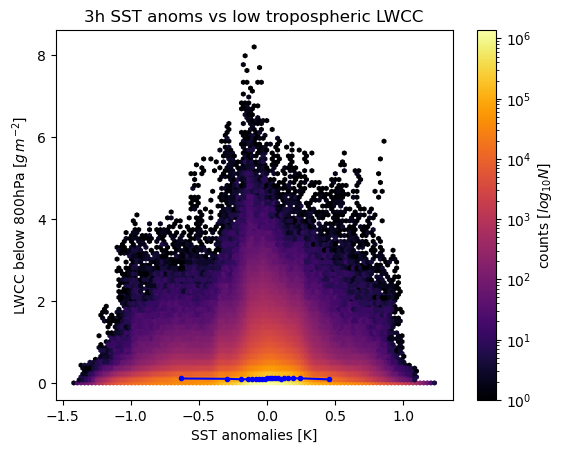

In [92]:
x = dsst.values
y = LWP_lowTropo.values
    
density_hexbin(x, y, plot_fit=False, fit=None, corcoe=None, grdsz=100, \
                        title=r'3h SST anoms vs low tropospheric LWCC', xlabel='SST anomalies [K]', ylabel='LWCC below 800hPa [$g\,m^{-2}$]', colormap='inferno', pos=pos)

plt.plot(pdist_dsst, pdist_LWPlow, '.-b')

# plt.savefig('/venus/tesi_ale/img_EU/QCLOUD/hourly/FEB/scatter_dsst_LWCCLow_3h.png')

In [21]:
# ratio = LWP_lowTropo.values/LWP_total.values
ratio_day = LWP_lowTropo_day.values/LWP_total_day.values
ratio_day_mask = np.where(LWP_total_day.values>0, 1, np.nan)
# ratio = ratio.where(ratio.values>0, other=np.nan, drop=False)

In [28]:
ratio_log, ratio_day_log = ratio[ratio>0], ratio_day[ratio_day>0]

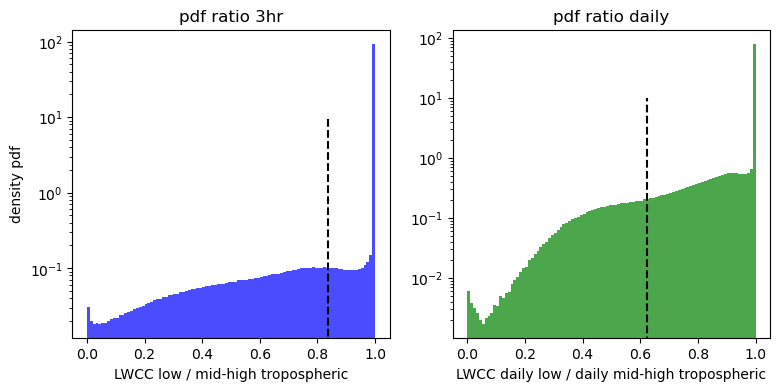

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# Plot the first histogram (pdf ratio)
axs[0].hist(ratio_log.flatten(), density=True, bins=100, alpha=0.7, color='blue')
axs[0].vlines(np.nanpercentile(ratio, 5), ymin=0, ymax=10, color='k', linestyle='--')

axs[0].set_title('pdf ratio 3hr')
axs[0].set_xlabel('LWCC low / mid-high tropospheric')
axs[0].set_ylabel('density pdf')
axs[0].set_yscale('log')



# Plot the second histogram (pdf ratio daily)
axs[1].hist(ratio_day_log.flatten(), density=True, bins=100, alpha=0.7, color='green')
axs[1].vlines(np.nanpercentile(ratio_day, 5), ymin=0, ymax=10, color='k', linestyle='--')

axs[1].set_title('pdf ratio daily')
axs[1].set_xlabel('LWCC daily low / daily mid-high tropospheric')
axs[1].set_yscale('log')
# axs[1].set_ylabel('density pdf')

In [43]:
print(np.nanpercentile(ratio_day, 5))
print(np.nanpercentile(ratio_day, 25))
print(np.nanpercentile(ratio_day, 50))
print(np.nanpercentile(ratio_day, 75))
print(np.nanpercentile(ratio_day, 95))

0.6237321704290941
1.0
1.0
1.0
1.0


/venus/tesi_ale/img_EU/QCLOUD/map_LWPlow_feb_SMOC3.png


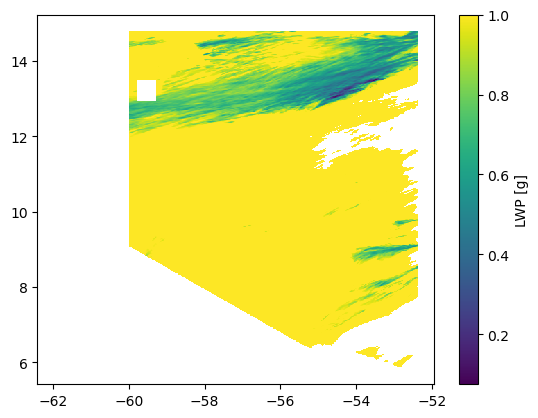

In [40]:
step = int(15)

time = ['01:00', '04:00', '07:00', '10:00', '13:00', '16:00', '19:00', '22:00']
day = int(step/8) ; index_time = step%8

plt.pcolormesh(lon, lat, ratio_day[step,:,:], vmax=1)
plt.colorbar(label='LWP [g]')
# plt.title(f'LWP ratio, Feb {day}, {time[index_time]}')

path_img = '/venus/tesi_ale/img_EU/QCLOUD/' 
filename = path_img + 'map_LWPlow_feb_SMOC3.png'
# plt.savefig(filename)
print(filename)
del filename

In [35]:
x[~np.isnan(x)].flatten().shape

(72583056,)

In [145]:
nan_number(LWP_lowTropo.values*sea_mask_modified_nan)

40908096

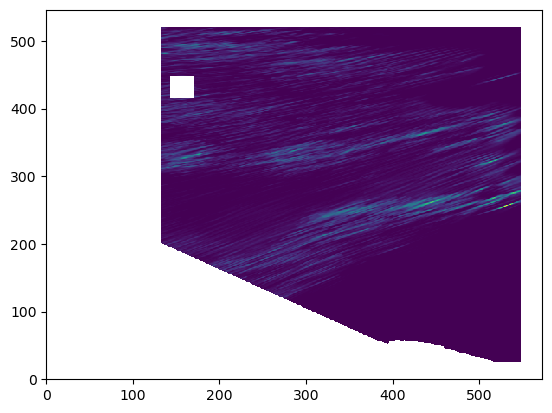

In [137]:
plt.pcolormesh((LWP_lowTropo.values*sea_mask_modified_nan)[50])

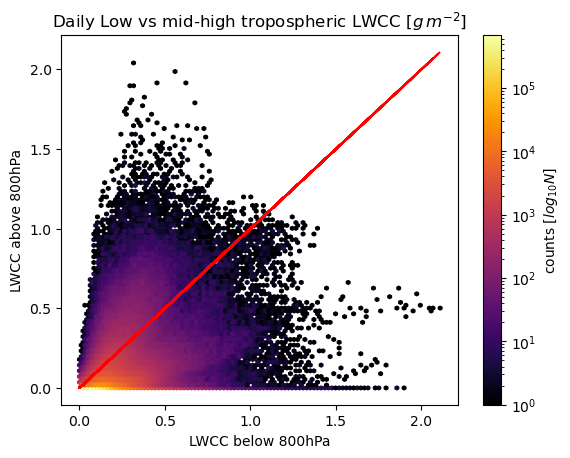

In [46]:
pos = [0.02,0.95]    

x = LWP_lowTropo_day.values*sea_mask_modified_nan
y = (LWP_total_day.values -LWP_lowTropo_day.values)*sea_mask_modified_nan
    
density_hexbin(x, y, plot_fit=False, fit=None, corcoe=None, grdsz=100, \
                        title=r'Daily Low vs mid-high tropospheric LWCC [$g\,m^{-2}$]', xlabel='LWCC below 800hPa', ylabel='LWCC above 800hPa', colormap='inferno', pos=pos)

plt.plot(x.flatten(), x.flatten(), '--r')

# plt.savefig('/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/scatter_LWCClow-midhigh_daily.png')


In [47]:
mid_high_lessThan_low = np.nansum(y.flatten()<x.flatten() )
mid_high_lessThan_low/np.nansum(~np.isnan(x))

0.9002638499723868

## IDENTIFY WHERE RAIN IS HAPPENING MOST FREQUENTLY

In [12]:
rain = ds_hourly['RAIN'].where(sea_mask_modified, drop=False);
rain_3h = rain[::3]*sea_mask_modified_nan

In [13]:
mean_rain_day = rain.groupby('time_counter.day').mean()*sea_mask_modified_nan
sum_rain_day = rain.groupby('time_counter.day').sum(dim='time_counter')*sea_mask_modified_nan

In [107]:
non_nan_number(sum_rain_day.values)

5113512

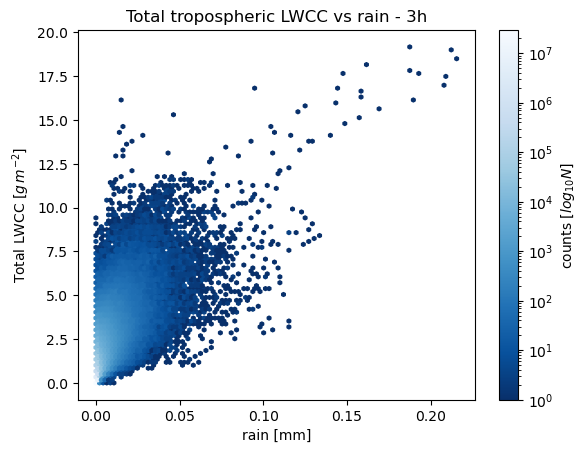

In [58]:
pos = [0.02,0.95]    

x = rain.values
y = LWP_total.values #- LWP_lowTropo.values   # -
    
density_hexbin(x, y, plot_fit=False, fit=None, corcoe=None, grdsz=100, \
                        title=r'Total tropospheric LWCC vs rain - 3h', xlabel='rain [mm]', ylabel='Total LWCC [$g\,m^{-2}$]', colormap='Blues_r', pos=pos)

# plt.plot(x.flatten(), x.flatten(), '--r')

# plt.savefig('/venus/tesi_ale/img_EU/QCLOUD/hourly/FEB/scatter_LWCCTot-rain_3h.png')


### comparing rain and ratio

In [123]:
perc_step = 5
nbins= int(100/perc_step)   #.values[LWP_total.values!=0]

ratio_percentiles, rain_percentiles, pstd_rain_ratio, pstderr_rain_ratio, pnpoints_rain_ratio, ppvalue_rain_ratio = \
distrib_2d(ratio, rain.values, perc_step, nbins, popmean, perc_fixbin='perc')

In [20]:
np.sum(ratio_day[~np.isnan(ratio_day)])

4496721.500349311

Text(0.205, 0.62, '95%')

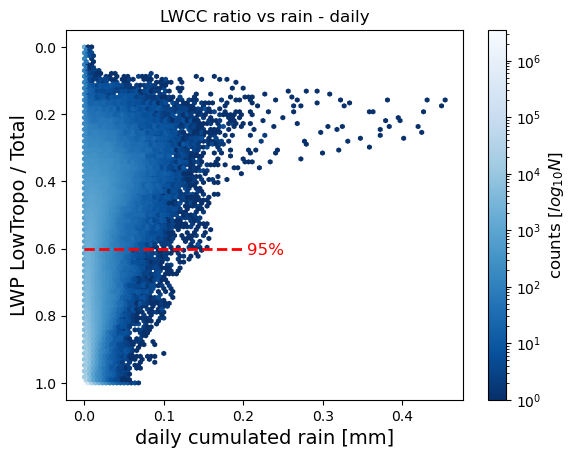

In [55]:
pos = [0.02,0.95]    

daily = True

x = sum_rain_day.values[LWP_total_day.values!=0] if daily else rain_3h.values[LWP_total.values!=0]
y = ratio_day if daily else ratio

fig, ax = plt.subplots(1)

# x_perc = [np.nanpercentile(x, 0.5), np.nanpercentile(x,2), np.nanpercentile(x,5), np.nanpercentile(x,50)] #, np.nanpercentile(x,95)]
# y_perc = [np.nanpercentile(y, 0.5), np.nanpercentile(y,2), np.nanpercentile(y,5), np.nanpercentile(y,50)]#, np.nanpercentile(y,95)]

ax.invert_yaxis()
density_hexbin(x, y, plot_fit=False, fit=None, corcoe=None, grdsz=100, \
               title=r'LWCC ratio vs rain - daily', xlabel='daily cumulated rain [mm]', ylabel='LWP LowTropo / Total', colormap='Blues_r', pos=pos)

ax.hlines(0.6, xmin=0, xmax=0.2, color='red', linestyle='--', linewidth=2)
ax.annotate('95%', xy=(0.205, 0.62), fontsize=12, color='red') #, xytext=(0.22, 0.6))

# ax.plot(x_perc, y_perc, '*k')

# plt.savefig('/venus/tesi_ale/img_EU/QCLOUD/hourly/FEB/scatter_LWCC-Ratio-rain_daily.png')

In [47]:
percentage = np.sum(np.where(ratio_day < 0.6, 1, 0))/np.sum(np.where(sum_rain_day.values[LWP_total_day.values!=0] >= 0.0, 1, 0))
percentage

0.045264619688755295

In [45]:
# (np.sum(sum_rain_day.values[~np.isnan(sum_rain_day.values)]))

np.sum(np.where(sum_rain_day.values[LWP_total_day.values!=0] >= 0.0, 1, 0))

4733189

## LINK OLR WITH LWP_MID_HIGH

In [59]:
OLR = xr.open_dataset(wrf_files[files_ls.index('OLR.nc')])
OLR = OLR['OLR'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
OLR = OLR.where(sea_mask_modified, drop=False)

OLR_day = OLR.groupby('time_counter.day').mean()

In [60]:
s = 300
dOLR_day = np.zeros_like(OLR_day)

for t in range(0,OLR_day.shape[0]):
    if t % 10 == 0:
        print(t)
        
    OLRave = gm.nan_gaussian_filter(OLR_day[t],s)                            
    dOLR_day[t] = OLR_day[t] - OLRave

0
10
20


Text(-62, 6, 'blue contours: low clouds \nyellow contours: deeper clouds')

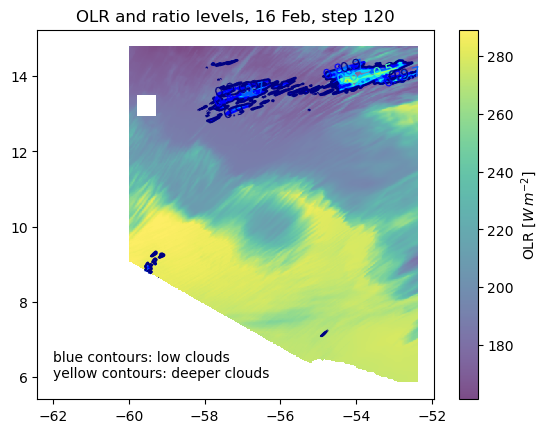

In [102]:
miao = plt.pcolormesh(lon, lat, OLR[120], alpha=0.7) #, vmin=-30, vmax=30, cmap='seismic')  #, vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(miao, label=r'OLR [$W\,m^{-2}$]')
# plt.pcolormesh(lon, lat, ratio[119])
conts = plt.contour(lon, lat, ratio[120], levels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], cmap='jet_r')
plt.clabel(conts, inline=True, fontsize=10)
plt.title('OLR and ratio levels, 16 Feb, step 120')

plt.annotate('blue contours: low clouds \nyellow contours: deeper clouds', 
             xy=(-62, 6), 
             xytext=(-62, 6),
             fontsize=10,
             color='black')

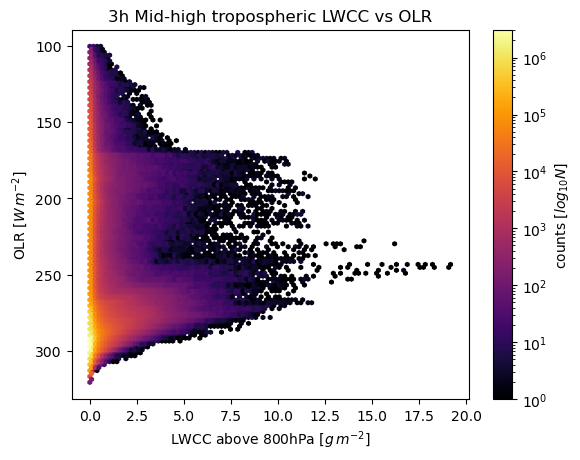

In [76]:
pos = [0.02,0.95]    

x = OLR.values
dx = dOLR_day

y = LWP_total.values #- LWP_lowTropo.values   
dy = dLWP_total_day #- dLWP_lowTropo_day

fig, ax = plt.subplots(1)
ax.invert_yaxis()
density_hexbin(y, x, plot_fit=False, fit=None, corcoe=None, grdsz=100, \
                        title=r'3h Mid-high tropospheric LWCC vs OLR', xlabel='LWCC above 800hPa [$g\,m^{-2}$]', ylabel=r'OLR [$W\,m^{-2}$]', colormap='inferno', pos=pos)

plt.savefig('/venus/tesi_ale/img_EU/OLR/scatter_OLR_midhigh_3h.png')

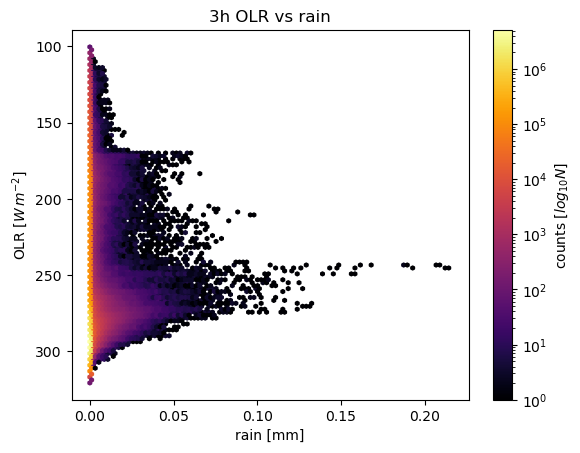

In [72]:
pos = [0.02,0.95]    

x = rain.values

y = OLR.values #- LWP_lowTropo.values   

fig, ax = plt.subplots(1)

ax.invert_yaxis()
density_hexbin(x, y, plot_fit=False, fit=None, corcoe=None, grdsz=100, \
                        title=r'3h OLR vs rain', xlabel=r'rain [mm]', ylabel='OLR [$W\,m^{-2}$]', colormap='inferno', pos=pos)

# plt.savefig('/venus/tesi_ale/img_EU/OLR/scatter_OLR_rain_3h.png')

# Plotting starts from here

In [ ]:
# retrieve SST and PBLH

In [29]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.



In [30]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2019-12-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

# lat and lon
lon_M = ds_hourly['nav_lon'].values
lat_M = ds_hourly['nav_lat'].values

In [31]:
sst = ds_hourly['SST'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))#.groupby('time_counter.day').mean()            
sst = sst.where(sea_mask_modified, drop=False)
sst = sst[::3,:,:]   # 3h data

# FULL FIELDS

In [32]:
## import LWP_lowTropo
LWP_lowTropo = xr.open_dataset('/venus/tesi_ale/data_EU/QCLOUD/hourly/FEB/qcloud_grams_percell.nc')
LWP_lowTropo = LWP_lowTropo['LWP_lowTropo'].where(sea_mask_modified, drop=False)

/venus/tesi_ale/img_EU/QCLOUD/scatter_sst_LWPlow_feb.png


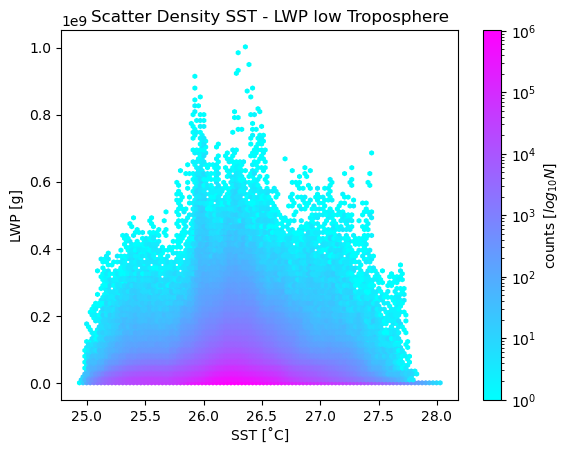

In [37]:

x = sst.values-273.15
y = -LWP_lowTropo.values

#fit, corcoe, p_value, p_value_cannelli, sigmas_anoms = slopes_r_p_mix(x, y, nt, nskip)
title='    Scatter Density SST - LWP low Troposphere'
xlabel='SST [˚C]'
ylabel='LWP [g]'

'''plt.hexbin(x, y, gridsize=grdsz, bins='log', cmap=colormap, mincnt=1)'''
    
fig = density_hexbin(x,y,fit=None,corcoe=None,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='cool', pos=[0.1, 0.9])

'''if dsst:
    plt.vlines(0, ymin=miny, ymax=maxy, color='red', linewidth=1)
    plt.hlines(0, xmin=minx, xmax=maxx, color='red', linewidth=1)'''
    
'''if p_value_cannelli < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')'''

    

path_img = '/venus/tesi_ale/img_EU/QCLOUD/' 
filename = path_img + 'scatter_sst_LWPlow_feb.png' # if dsst else path_img + 'scatterFIT_sst_RH_feb.png'
plt.savefig(filename)
print(filename)
del filename

# now select only points with LWP != 0 

/venus/tesi_ale/img_EU/QCLOUD/scatter_sst_LWPlow_feb_LWPOnly.png


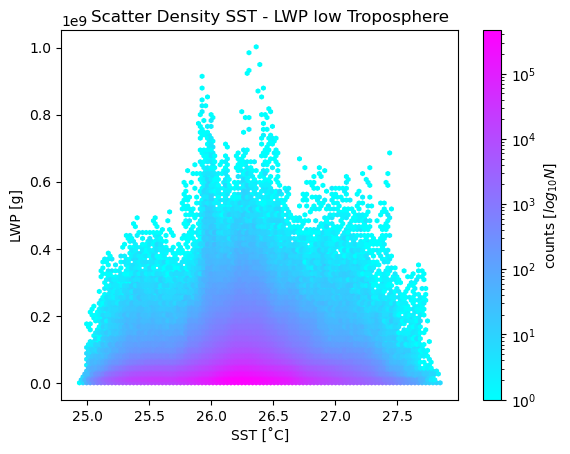

In [39]:

x = sst.values-273.15;  x = x[LWP_lowTropo.values<0]
y = -LWP_lowTropo.values[LWP_lowTropo.values<0]

#fit, corcoe, p_value, p_value_cannelli, sigmas_anoms = slopes_r_p_mix(x, y, nt, nskip)
title='    Scatter Density SST - LWP low Troposphere'
xlabel='SST [˚C]'
ylabel='LWP [g]'

'''plt.hexbin(x, y, gridsize=grdsz, bins='log', cmap=colormap, mincnt=1)'''
    
fig = density_hexbin(x,y,fit=None,corcoe=None,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='cool', pos=[0.1, 0.9])

'''if dsst:
    plt.vlines(0, ymin=miny, ymax=maxy, color='red', linewidth=1)
    plt.hlines(0, xmin=minx, xmax=maxx, color='red', linewidth=1)'''
    
'''if p_value_cannelli < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')'''

    

path_img = '/venus/tesi_ale/img_EU/QCLOUD/' 
filename = path_img + 'scatter_sst_LWPlow_feb_LWPOnly.png' # if dsst else path_img + 'scatterFIT_sst_RH_feb.png'
# plt.savefig(filename)
print(filename)
del filename

# look at daily behaviours

In [12]:
LWP_lowTropo_day = LWP_lowTropo.groupby('time_counter.day').mean()

/venus/tesi_ale/img_EU/QCLOUD/scatter_sst_LWPlow_feb_LWPOnly_Daily.png


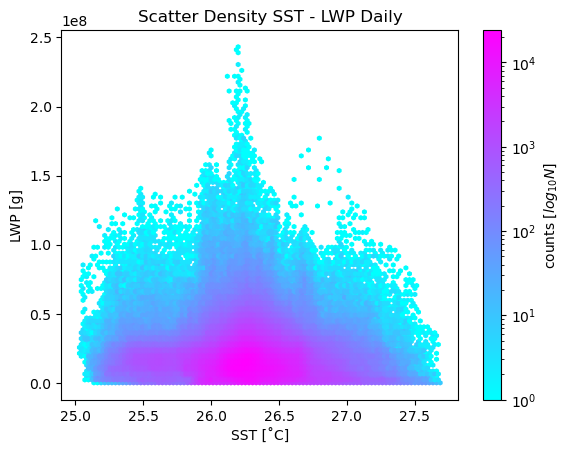

In [55]:

x = sst_day.values-273.15;  x = x[LWP_lowTropo_day.values<0]
y = -LWP_lowTropo_day.values[LWP_lowTropo_day.values<0]

#fit, corcoe, p_value, p_value_cannelli, sigmas_anoms = slopes_r_p_mix(x, y, nt, nskip)
title='    Scatter Density SST - LWP Daily'
xlabel='SST [˚C]'
ylabel='LWP [g]'

    
fig = density_hexbin(x,y,fit=None,corcoe=None,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='cool', pos=[0.1, 0.9])

    

path_img = '/venus/tesi_ale/img_EU/QCLOUD/' 
filename = path_img + 'scatter_sst_LWPlow_feb_LWPOnly_Daily.png' # if dsst else path_img + 'scatterFIT_sst_RH_feb.png'
#plt.savefig(filename)
print(filename)
del filename

<xarray.DataArray 'dsst_day' (day: 29, lat: 546, lon: 573)>
[9072882 values with dtype=float64]
Dimensions without coordinates: day, lat, lon
Attributes:
    long_name:  Anomalies at 200km of daily SST with latest mask

/venus/tesi_ale/img_EU/QCLOUD/map_LWPlow_feb_SMOC3.png


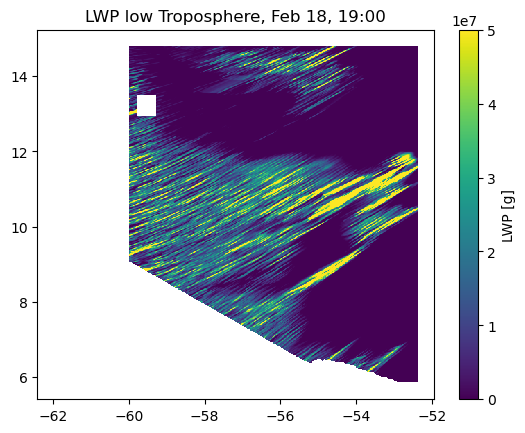

In [53]:
step = int(150)

time = ['01:00', '04:00', '07:00', '10:00', '13:00', '16:00', '19:00', '22:00']
day = int(step/8) ; index_time = step%8

plt.pcolormesh(lon_M, lat_M, -LWP_lowTropo[step,:,:], vmax=0.5e8)
plt.colorbar(label='LWP [g]')
plt.title(f'LWP low Troposphere, Feb {day}, {time[index_time]}')

path_img = '/venus/tesi_ale/img_EU/QCLOUD/' 
filename = path_img + 'map_LWPlow_feb_SMOC3.png'
# plt.savefig(filename)
print(filename)
del filename

# ANOMALIES

In [33]:
fst = np.load('/venus/tesi_ale/data_EU/SST/daily/FEB/dsst_fst.npy')
snd = np.load('/venus/tesi_ale/data_EU/SST/daily/FEB/dsst_snd.npy')
trd = np.load('/venus/tesi_ale/data_EU/SST/daily/FEB/dsst_trd.npy')
lst = np.load('/venus/tesi_ale/data_EU/SST/daily/FEB/dsst_lst.npy')


dsst = np.concatenate([fst, snd, trd, lst], axis=0)

dsst = xr.DataArray(
    data=dsst,
    dims=['time_counter', 'y_grid_M', 'x_grid_M'],
    attrs={'units': 'K', 'long_name': '3hr SST anomalies at 200km with first mask'}
)

dsst.name = 'dSST'

ds = dsst.to_dataset(name='dSST')
ds.to_netcdf('/venus/tesi_ale/data_EU/SST/hourly/FEB/dSST_3h_feb.nc')

In [40]:
dsst = xr.open_dataset('/venus/tesi_ale/data_EU/SST/hourly/FEB/dSST_feb.nc')
dsst = dsst['dSST'].where(sea_mask_modified, drop=False)

/venus/tesi_ale/img_EU/QCLOUD/scatter_dsst_LWPlow_feb.png


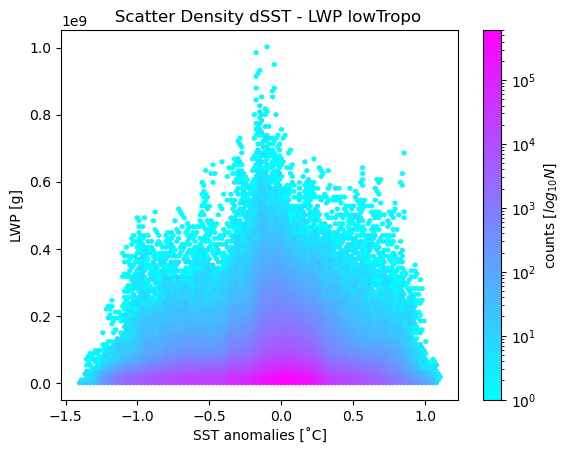

In [18]:

x = dsst.values;  x = x[LWP_lowTropo.values<0]
y = -LWP_lowTropo.values[LWP_lowTropo.values<0]

#fit, corcoe, p_value, p_value_cannelli, sigmas_anoms = slopes_r_p_mix(x, y, nt, nskip)
title='   Scatter Density dSST - LWP lowTropo'
xlabel='SST anomalies [˚C]'
ylabel='LWP [g]'
    

fig = density_hexbin(x,y,fit=None,corcoe=None,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='cool', pos=[0.1, 0.9])

'''if dsst:
    plt.vlines(0, ymin=miny, ymax=maxy, color='red', linewidth=1)
    plt.hlines(0, xmin=minx, xmax=maxx, color='red', linewidth=1)'''
    
'''if p_value_cannelli < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')'''

    

path_img = '/venus/tesi_ale/img_EU/QCLOUD/' 
filename = path_img + 'scatter_dsst_LWPlow_feb.png'
# plt.savefig(filename)
print(filename)
del filename

# look at daily behaviours

/venus/tesi_ale/img_EU/QCLOUD/scatter_dsst_LWPlow_feb.png


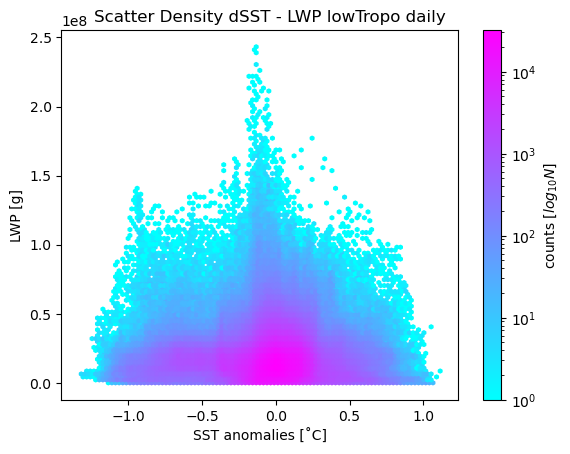

In [19]:

x = dsst_day.values;  x = x[LWP_lowTropo_day.values<0]
y = -LWP_lowTropo_day.values[LWP_lowTropo_day.values<0]

#fit, corcoe, p_value, p_value_cannelli, sigmas_anoms = slopes_r_p_mix(x, y, nt, nskip)
title='    Scatter Density dSST - LWP lowTropo daily'
xlabel='SST anomalies [˚C]'
ylabel='LWP [g]'
    

fig = density_hexbin(x,y,fit=None,corcoe=None,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='cool', pos=[0.1, 0.9])

'''if dsst:
    plt.vlines(0, ymin=miny, ymax=maxy, color='red', linewidth=1)
    plt.hlines(0, xmin=minx, xmax=maxx, color='red', linewidth=1)'''
    
'''if p_value_cannelli < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')'''

    

path_img = '/venus/tesi_ale/img_EU/QCLOUD/' 
filename = path_img + 'scatter_dsst_LWPlow_feb_daily.png' 
plt.savefig(filename)
print(filename)
del filename

ANOMALIES OF LWP 

In [31]:
s = 250

lwp = xr.open_dataset('/venus/tesi_ale/data_EU/QCLOUD/hourly/FEB/qcloud_grams_percell.nc')
lwp = -lwp['LWP_lowTropo'].where(sea_mask_modified, drop=False)

dLWP = np.zeros(lwp.shape)
local_dsst = np.zeros_like(dsst.values)

for t in range(0,lwp.shape[0]):
    if t % 10 == 0:
        print(t)
        
    ave = gm.nan_gaussian_filter(dsst[t].values,s)
    local_dsst[t] = dsst[t] - ave
    
    lwp_ave = gm.nan_gaussian_filter(lwp[t].values,s)                             
    dLWP[t] = lwp[t] - lwp_ave
    
del lwp

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230


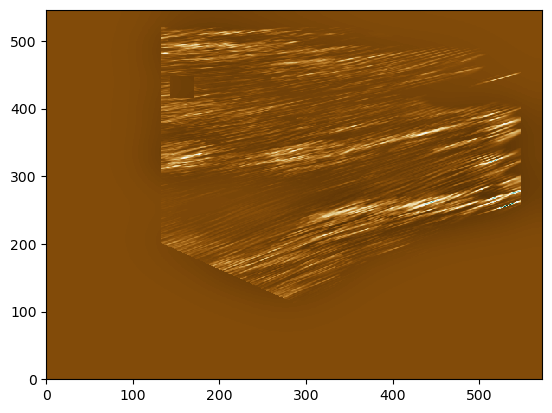

In [47]:
plt.pcolormesh(dLWP[50], cmap='BrBG')

In [29]:
dLWP = xr.DataArray(
    name='dLWP',
    data=dLWP,
    dims=['time_counter', 'y_grid_M', 'x_grid_M'],
    attrs={'units': 'K', 'long_name': '3hr SST anomalies at 200km with first mask'}
)

dLWP = dLWP.where(sea_mask_modified, drop=False)

/venus/tesi_ale/img_EU/QCLOUD/scatter_dsst_dLWPlow_500km.png


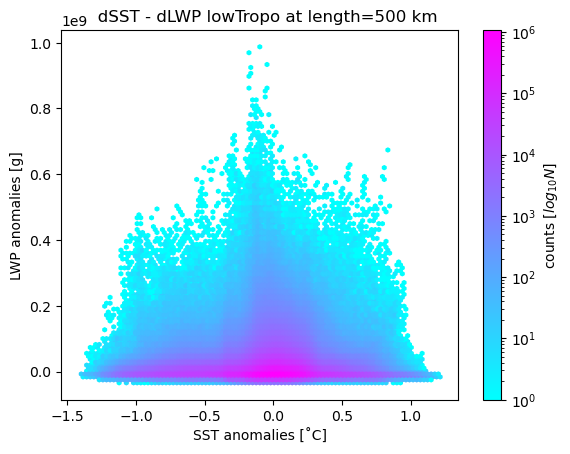

In [33]:
x = local_dsst  #.values
y = dLWP  #.values

#fit, corcoe, p_value, p_value_cannelli, sigmas_anoms = slopes_r_p_mix(x, y, nt, nskip)
title=f'   dSST - dLWP lowTropo at length={2*s} km'
xlabel='SST anomalies [˚C]'
ylabel='LWP anomalies [g]'
    

fig = density_hexbin(x,y,fit=None,corcoe=None,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='cool', pos=[0.1, 0.9])

'''if dsst:
    plt.vlines(0, ymin=miny, ymax=maxy, color='red', linewidth=1)
    plt.hlines(0, xmin=minx, xmax=maxx, color='red', linewidth=1)'''
    
'''if p_value_cannelli < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')'''

    

path_img = '/venus/tesi_ale/img_EU/QCLOUD/' 
filename = path_img + 'scatter_dsst_dLWPlow_500km.png' 
# plt.savefig(filename)
print(filename)
del filename



# WINDSTREAKS?

In [13]:
# LOAD dWS
dwind_speed = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/dwind_speed_day_feb.npy')
dwind_speed = dwind_speed*sea_mask_modified_nan

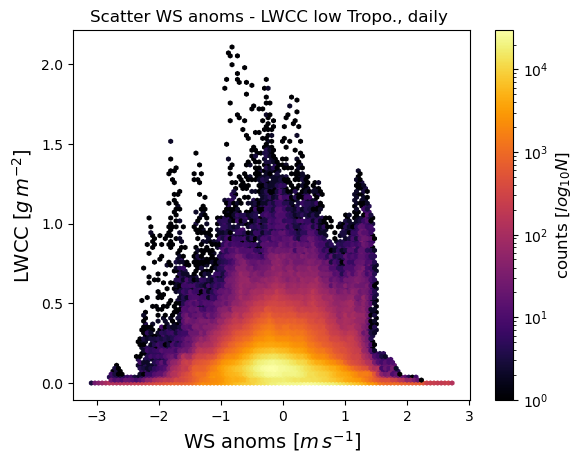

In [24]:
x = dwind_speed[:,0,:,:]
y = LWP_lowTropo_day.values*sea_mask_modified_nan

fit, corcoe, p_value, p_value_cannelli, sigmas_anoms = slopes_r_p_mix(x, y, nt, nskip)
title='Scatter WS anoms - LWCC low Tropo., daily '
xlabel=r'WS anoms [$m\,s^{-1}$]'
ylabel=r'LWCC [$g\,m^{-2}$]'
    
# xx = pdist_dsst
# yy = pdist_dLWPLow


fig = density_hexbin(x,y,plot_fit=False,fit=None,corcoe=None,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=[0.1,0.9])
# plt.plot(xx, yy, 'b*')

In [31]:
# load U component
U_day = xr.open_dataset(wrf_files[files_ls.index('U.nc')])
U_day = U_day['U'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))#.groupby('time_counter.day').mean()

i = np.arange(0, sea_mask.shape[1])
U_day = 0.5*(U_day[:,:,:,i] + U_day[:,:,:,i+1])

In [32]:
# select data oversea
U_day = U_day.where(sea_mask_modified, drop=False)

In [33]:
# load U component
V_day = xr.open_dataset(wrf_files[files_ls.index('V.nc')])
V_day = V_day['V'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))#.groupby('time_counter.day').mean()

j = np.arange(0, sea_mask.shape[0])
V_day = 0.5*(V_day[:,:,j,:] + V_day[:,:,j+1,:])

In [34]:
# select data oversea
V_day = V_day.where(sea_mask_modified, drop=False)

In [35]:
wind_speed = np.sqrt(U_day.values**2+V_day.values**2)

In [37]:
wind_speed = xr.DataArray(wind_speed, name='wind_speed_3h', dims=['time_counter', 'lev_M', 'lat', 'lon'],\
                          coords={'time_counter':U_day.time_counter} )
wind_speed.attrs['long name'] = 'wind speed 3h offshore, m/s'

ds_ws = xr.Dataset()
ds_ws = ds_ws.assign(wind_speed_3h=wind_speed)

wind_speed_day = wind_speed.groupby('time_counter.day').mean()*sea_mask_modified_nan

wind_speed_day = xr.DataArray(wind_speed_day, name='wind_speed_day', dims=['day', 'lev_M', 'lat', 'lon'])
wind_speed_day.attrs['long name'] = 'wind speed daily offshore, m/s'

ds_ws = ds_ws.assign(wind_speed_day=wind_speed_day)

ds_ws.to_netcdf('/venus/tesi_ale/data_EU/WIND/daily/FEB/wind_speed_3h_day.nc')

In [23]:
ds_ws = xr.open_dataset('/venus/tesi_ale/data_EU/WIND/daily/FEB/wind_speed_3h_day.nc')
wind_speed_day = ds_ws['wind_speed_day']*open_ocean_mask

ds_ws.close()

In [24]:
dwind_speed_day = np.zeros(wind_speed_day.shape)

s = 20

for t in range(0,wind_speed_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    for h in range(0,wind_speed_day.shape[1]):
        ws_ave = gm.nan_gaussian_filter(wind_speed_day.values[t,h],s)                            
        dwind_speed_day[t,h] = wind_speed_day.values[t,h] - ws_ave
        

0
10
20


In [25]:
dLWP_lowTropo_day = np.zeros(LWP_lowTropo_day.shape)

for t in range(0,wind_speed_day.shape[0]):
    if t % 10 == 0:
        print(t)
    lwp_ave = gm.nan_gaussian_filter(LWP_lowTropo_day.values[t]*open_ocean_mask, s)
    dLWP_lowTropo_day[t] = LWP_lowTropo_day.values[t]*open_ocean_mask - lwp_ave

0
10
20


slope p value: 1.741

sigma slope: 0.112



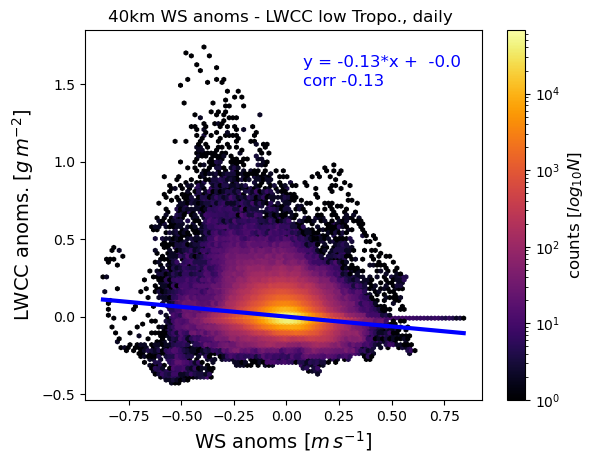

In [32]:
x = dwind_speed_day[:,0,:,:]*open_ocean_mask
y = dLWP_lowTropo_day*open_ocean_mask

fit, corcoe, p_value, p_value_cannelli, sigmas_anoms = slopes_r_p_mix(x, y, nt, nskip)
title='40km WS anoms - LWCC low Tropo., daily '
xlabel=r'WS anoms [$m\,s^{-1}$]'
ylabel=r'LWCC anoms. [$g\,m^{-2}$]'
    
# xx = pdist_dsst
# yy = pdist_dLWPLow


fig = density_hexbin(x,y,plot_fit=True,fit=fit,corcoe=corcoe,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=[0.55,0.9])
# plt.plot(xx, yy, 'b*')


print(f'slope p value: {round(p_value_cannelli,3)}\n')
print(f'sigma slope: {round(sigmas_anoms[0],3)}\n')

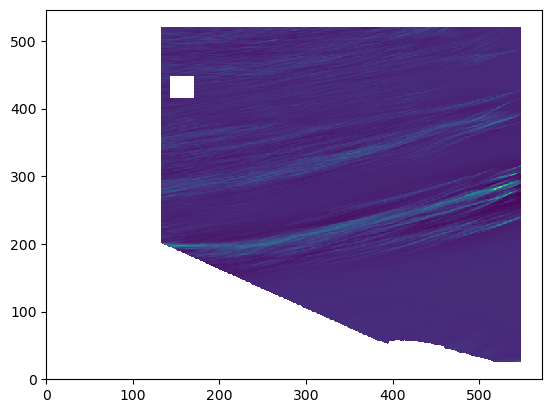

In [22]:
plt.pcolormesh(dLWP_lowTropo_day[5])

# disregard from here on

In [19]:
# PBLH
'''PBLH_dec = ds_hourly['PBLH'].sel(time_counter=slice('2019-12-01T01:30:00.000000000', '2020-01-01T01:30:00.000000000')).groupby('time_counter.day').mean()            
PBLH_jan = ds_hourly['PBLH'].sel(time_counter=slice('2020-01-01T01:30:00.000000000', '2020-02-01T01:30:00.000000000')).groupby('time_counter.day').mean()'''            
PBLH_feb = ds_hourly['PBLH'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000')).groupby('time_counter.day').mean()            

PBLH_day = PBLH_feb   #xr.concat([PBLH_dec, PBLH_jan, PBLH_feb], dim='day')

del PBLH_feb  #  PBLH_dec, PBLH_jan, PBLH_feb 

In [20]:
PBLH_day = PBLH_day.where(sea_mask, drop=False)

In [ ]:
T2 = ds_hourly['T2'].groupby('time_counter.day').mean()
T2 = T2.where(sea_mask, drop=False).values

In [ ]:
buoya = sst_day - T2

In [ ]:
# distributions QCLOUD data - full dataset

In [15]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.

perc_step = 5
nbins = int(100/perc_step) # Number of bins.

In [35]:
# percentiles
# x,y,perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top, perc_fixbin
# dist_x, dist_y, std_y, stderr_y, npoints_y, pvalue_y, pvalue_y_sub


pdist_sst, pdist_QCLOUD, pstd_QCLOUD, pstderr_QCLOUD, pnpoints_QCLOUD, ppvalue_QCLOUD_sub = \
dist_3d_subsample(sst_day.values, QCLOUD.values, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [36]:
## save data
p_cl_sst = [pdist_sst, pdist_QCLOUD, pstd_QCLOUD, pstderr_QCLOUD, pnpoints_QCLOUD, ppvalue_QCLOUD_sub]
my_save_data('/venus/tesi_ale/data_EU/QCLOUD/daily/FEB/pdistrs_QCLOUD_SST_day_feb.npy', p_cl_sst)

In [23]:
'''# bins
dist_sst, dist_QCLOUD, std_QCLOUD, stderr_QCLOUD, npoints_QCLOUD, pvalue_QCLOUD_sub = \
dist_3d_subsample(sst_day.values, QCLOUD.values, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='fb')'''

0
10
20
30


In [37]:
#  PBLH distrib
with open('/venus/tesi_ale/data_EU/PBLH/daily/FEB/pdistrs_PBLH_SST_day_feb.npy', 'rb') as f:
    pdist_sst = np.load(f)
    pdist_PBLH_sst = np.load(f)
    f.close()


# # perc
# pdist_sst, pdist_PBLH_sst, pstd_PBLH, pstderr_PBLH, pnpoints_PBLH, ppvalue_PBLH = distrib_2d(sst_day.values, PBLH_day.values, perc_step, nbins, popmean, perc_fixbin = 'perc')

'''# bins
dist_sst, dist_PBLH_sst, std_PBLH, stderr_PBLH, npoints_PBLH, pvalue_PBLH = distrib_2d(sst_day.values, PBLH_day.values, perc_step, nbins, popmean, perc_fixbin = 'fb')'''

"# bins\ndist_sst, dist_PBLH_sst, std_PBLH, stderr_PBLH, npoints_PBLH, pvalue_PBLH = distrib_2d(sst_day.values, PBLH_day.values, perc_step, nbins, popmean, perc_fixbin = 'fb')"

/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/pdist_SST_QCLOUD_lowtropo_day_feb.png


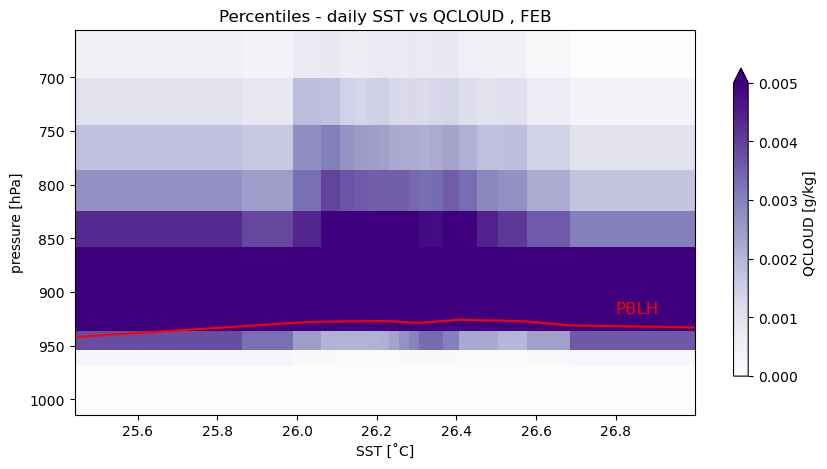

In [41]:
p_level_plot = int(18)

perc = True
title = 'Percentiles' if perc else 'Fixed bins'
x = pdist_sst if perc else dist_sst
var = pdist_QCLOUD[0:p_level_plot] if perc else dist_QCLOUD[0:p_level_plot]
minval = 0. ; maxval = 0.005

fig, ax1 = plt.subplots(figsize=(10, 5))  ; ax1.invert_yaxis()
p1 = ax1.pcolormesh(x-273.15, mean_vert_pres[0:p_level_plot], var*1000, vmin=minval, vmax=maxval, cmap='Purples') #pdist_dqvapor_dsst_day
ax1.set_xlabel('SST [˚C]'); ax1.set_ylabel('pressure [hPa]')
plt.title(f'{title} - daily SST vs QCLOUD , FEB')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='max')  
cbar.set_label('QCLOUD [g/kg]')

var_pbl = pdist_PBLH_sst if perc else dist_PBLH_sst
ax1.plot(x-273.15, var_pbl, '-r', linewidth=1.5)
ax1.text(26.8, 920, 'PBLH', fontsize=12, color='r')



# savefig
path_img = '/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/' #if perc else '/venus/tesi_ale/img_EU/QCLOUD/daily/bins/DJF/'
filename = path_img + 'pdist_SST_QCLOUD_lowtropo_day_feb.png' #if perc else path_img + 'bins_sst_qcloud_lowtropo_DJF.png'
# plt.savefig(filename)
print(filename)
del filename

In [43]:
# save distributions data
perc = False

path_to_data = '/venus/tesi_ale/results_EU/distributions/DJF/'
filename = path_to_data + 'perc/' if perc else path_to_data + 'fix_bin/'

# pdist_sst, pdist_QCLOUD
# save: choose each time a var to save
x = pdist_QCLOUD if perc else dist_QCLOUD
filename += 'QCLOUD/pdist_QCLOUD_sst_day_DJF.npy' if perc else 'QCLOUD/dist_QCLOUD_sst_day_DJF.npy'

print(filename)
#np.save(filename, x)
del filename

/venus/tesi_ale/results_EU/distributions/DJF/fix_bin/QCLOUD/dist_QCLOUD_sst_day_DJF.npy


In [13]:
with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dSST_day_feb.npy', 'rb') as f:
    dsst_day = np.load(f)

with open('/venus/tesi_ale/data_EU/QCLOUD/daily/FEB/dQCLOUD_day_feb.npy', 'rb') as f:
    dQCLOUD_day = np.load(f)

"with open('/venus/tesi_ale/data_EU/QCLOUD/daily/FEB/dQCLOUD_day_feb.npy', 'rb') as f:\n    dQCLOUD_day = np.load(f)"

In [11]:
# compute anomalies daily data
s = 100

'''dsst_day = np.zeros(sst_day.shape)'''
dQCLOUD_day = np.zeros(QCLOUD.values.shape)
'''dPBLH_day = np.zeros(PBLH_day.shape)'''


for t in range(0,QCLOUD.values.shape[0]):
    if t % 10 == 0:
        print(t)
    
    '''sst_ave = gm.nan_gaussian_filter(sst_day[t],s)                             
    dsst_day[t] = sst_day[t] - sst_ave
    
    pbl_ave = gm.nan_gaussian_filter(PBLH_day[t],s)                             
    dPBLH_day[t] = PBLH_day[t] - pbl_ave'''
    
    for h in range(0,QCLOUD.values.shape[1]):
        QCLOUD_ave = gm.nan_gaussian_filter(QCLOUD[t,h],s)                             
        dQCLOUD_day[t,h] = QCLOUD[t,h] - QCLOUD_ave

0
10
20


In [12]:
## save anomalies
my_save_data('/venus/tesi_ale/data_EU/QCLOUD/daily/FEB/dQCLOUD_day_feb.npy', [dQCLOUD_day])

In [ ]:
# compute distributions of ANOMALIES

In [16]:
# PERC DISTRIBUTION dQCLOUD vs dSST bin - DAILY + PVALUE SUBSAMPLED height dependent

pdist_dsst_day, pdist_dQCLOUD_day, pstd_dQCLOUD_day, pstderr_dQCLOUD_day, pnpoints_dQCLOUD, ppvalue_dQCLOUD_day_sub = \
dist_3d_subsample(dsst_day, dQCLOUD_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [17]:
## SAVE DQCLOUD
p_dqcl_dsst = [pdist_dsst_day, pdist_dQCLOUD_day, pstd_dQCLOUD_day, pstderr_dQCLOUD_day, pnpoints_dQCLOUD, ppvalue_dQCLOUD_day_sub]
my_save_data('/venus/tesi_ale/data_EU/QCLOUD/daily/FEB/pdistrs_dQCLOUD_dSST_day_feb.npy', p_dqcl_dsst)

In [27]:
# BIN DISTRIBUTION dQCLOUD vs dSST bin - DAILY + PVALUE SUBSAMPLED height dependent

'''dist_dsst_day, dist_dQCLOUD_day, std_dQCLOUD_day, stderr_dQCLOUD_day, npoints_QCLOUD, pvalue_dQCLOUD_day_sub = \
dist_3d_subsample(dsst_day, dQCLOUD_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='fb')'''

0
10
20
30


In [20]:
# DISTRIBUTION PBLH  

with open('/venus/tesi_ale/data_EU/PBLH/daily/FEB/pdistrs_PBLH_dSST_day_feb.npy', 'rb') as f:
    pdist_dsst = np.load(f)
    pdist_PBLH_dsst = np.load(f)
    # other data missing
    f.close()


'''perc_step = 5
nbins = int(100/perc_step) # Number of bins.

# # dPBLH vs dSST - DAILY
# pdist_dsst_day, pdist_dPBLH_day, pstd_dPBLH_day, pstderr_dPBLH_day, pnpoints_dPBLH_day, ppvalue_dPBLH_day = \
# distrib_2d(dsst_day, dPBLH_day, perc_step, nbins, popmean, 'perc')

# dSST vs PBLH 
pdist_dsst, pdist_PBLH_dsst, pstd_PBLH_dsst, pstd_err_PBLH_dsst, pnpoints_PBLH_dsst, ppvalue_PBLH_dsst = \
distrib_2d(dsst_day, PBLH_day.values, perc_step, nbins, popmean, perc_fixbin='perc')'''

'''# BINS
dist_dsst, dist_PBLH_dsst, std_PBLH_dsst, std_err_PBLH_dsst, npoints_PBLH_dsst, pvalue_PBLH_dsst = \
distrib_2d(dsst_day, PBLH_day.values, perc_step, nbins, popmean, perc_fixbin='fb')'''

"# BINS\ndist_dsst, dist_PBLH_dsst, std_PBLH_dsst, std_err_PBLH_dsst, npoints_PBLH_dsst, pvalue_PBLH_dsst = distrib_2d(dsst_day, PBLH_day.values, perc_step, nbins, popmean, perc_fixbin='fb')"

In [ ]:
#####   PLOTTING ANOMALIES DISTRIBUTIONSSSS   ######

/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/pdist_dsst_dqcloud_lowtropo_hatch.png


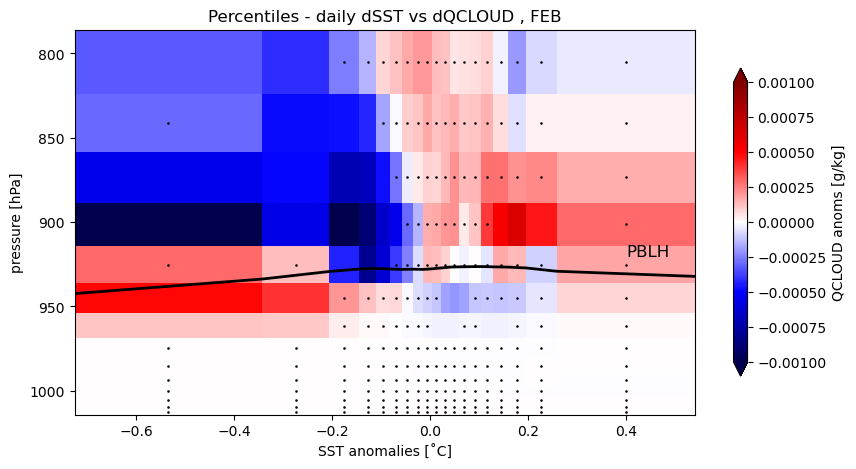

In [34]:
p_level_plot = int(15)

perc = True
title = 'Percentiles' if perc else 'Fixed bins'
x = pdist_dsst_day if perc else dist_dsst_day
var = pdist_dQCLOUD_day[0:p_level_plot] if perc else dist_dQCLOUD_day[0:p_level_plot]
minval = -0.001 ; maxval = -minval

fig, ax1 = plt.subplots(figsize=(10, 5))  ;  ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var*1000, vmin=minval, vmax=maxval, cmap='seismic')
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('pressure [hPa]')
plt.title(f'{title} - daily dSST vs dQCLOUD , FEB')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label('QCLOUD anoms [g/kg]')

var_pbl = pdist_PBLH_dsst if perc else dist_PBLH_dsst
ax1.plot(x, var_pbl, '-k', linewidth=2)
ax1.text(0.4, 920, 'PBLH', fontsize=12, color='k')




# DEF punti significativi (pvalue < 0.05)
pval = ppvalue_dQCLOUD_day_sub[0:p_level_plot] if perc else pvalue_dQCLOUD_day_sub[0:p_level_plot]
GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')



# savefig
path_img = '/venus/tesi_ale/img_EU/QCLOUD/daily/FEB/' if perc else '/venus/tesi_ale/img_EU/QCLOUD/daily/bins/FEB/'
filename = path_img + 'pdist_dsst_dqcloud_lowtropo_hatch.png' if perc else path_img + 'bins_dsst_dqcloud_lowtropo_hatch.png'
# plt.savefig(filename)
print(filename)
del filename

In [42]:
# my_save_data('/venus/tesi_ale/data_EU/PRES/daily/FEB/mean_vert_pres.npy', [mean_vert_pres])

In [10]:
#######  LINK BETWEEN    preci_water (dqcloud_sum) vs dsst

<xarray.DataArray 'QCLOUD' (day: 29, lev_M: 39, y_grid_M: 546, x_grid_M: 573)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
    nav_lon_grid_M  (y_grid_M, x_grid_M) float32 ...
    nav_lat_grid_M  (y_grid_M, x_grid_M) float32 ...
  * lev_M           (lev_M) float32 1.0 2.0 3.0 4.0 5.0 ... 36.0 37.0 38.0 39.0
  * day             (day) int64 1 2 3 4 5 6 7 8 9 ... 21 22 23 24 25 26 27 28 29
Dimensions without coordinates: y_grid_M, x_grid_M

In [16]:
preci_water = QCLOUD.sum(axis=1)      # SBAGLIATO!!!!! OCCHIO AI g/kg_air

In [27]:
# compute anomalies daily data
s = 100

dpreci_water = np.zeros(preci_water.values.shape)

devo_fare_dsst = True
if devo_fare_dsst:
    dsst_day = np.zeros(sst_day.shape)


for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    pw_ave = gm.nan_gaussian_filter(preci_water[t],s)                             
    dpreci_water[t] = preci_water[t] - pw_ave
    
    if devo_fare_dsst:
        sst_ave = gm.nan_gaussian_filter(sst_day[t],s)                             
        dsst_day[t] = sst_day[t] - sst_ave

    

0
10
20


In [53]:
# SST vs PRECI_WATER    #   x_index = int(0); y_index = int(0)
perc_step = 2
nbins = int(100/perc_step)
popmean = 0.

pdist_sst, pdist_pw_sst, pstd_pw_sst, pstd_err_pw_sst, pnpoints_pw_sst, ppvalue_pw_sst = \
distrib_2d(sst_day.values, preci_water.values, perc_step, nbins, popmean, perc_fixbin='perc')

dist_sst, dist_pw_sst, std_pw_sst, std_err_pw_sst, npoints_pw_sst, pvalue_pw_sst = \
distrib_2d(sst_day.values, preci_water.values, perc_step, nbins, popmean, perc_fixbin='fb')

In [54]:
# dSST vs PRECI_WATER    # x_index = int(1); y_index = int(1)
perc_step = 2
nbins = int(100/perc_step)
popmean = 0.

pdist_dsst, pdist_pw_dsst, pstd_pw_dsst, pstd_err_pw_dsst, pnpoints_pw_dsst, ppvalue_pw_dsst = \
distrib_2d(dsst_day, preci_water.values, perc_step, nbins, popmean, perc_fixbin='perc')

dist_dsst, dist_pw_dsst, std_pw_dsst, std_err_pw_dsst, npoints_pw_dsst, pvalue_pw_dsst = \
distrib_2d(dsst_day, preci_water.values, perc_step, nbins, popmean, perc_fixbin='fb')

In [55]:
# dSST vs dPRECI_WATER  # x_index = int(1); y_index = int(2)
perc_step = 2
nbins = int(100/perc_step)
popmean = 0.

pdist_dsst, pdist_dpw_dsst, pstd_dpw_dsst, pstd_err_dpw_dsst, pnpoints_dpw_dsst, ppvalue_dpw_dsst = \
distrib_2d(dsst_day, dpreci_water, perc_step, nbins, popmean, perc_fixbin='perc')

dist_dsst, dist_dpw_dsst, std_dpw_dsst, std_err_dpw_dsst, npoints_dpw_dsst, pvalue_dpw_dsst = \
distrib_2d(dsst_day, dpreci_water, perc_step, nbins, popmean, perc_fixbin='fb')

In [32]:
pdist_dpw_dsst.shape

(20,)

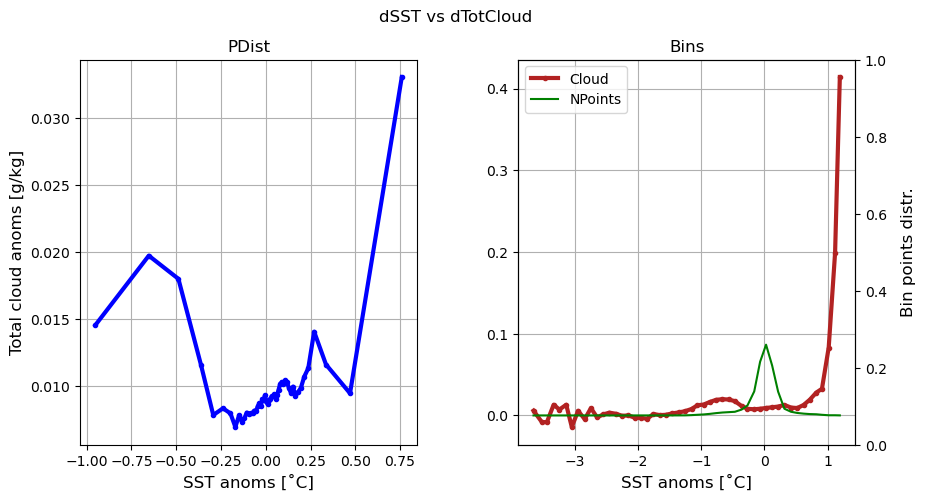

In [61]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

x_index = int(1); y_index = int(2)


if x_index == 0 and y_index == 0:
    xlab = 'SST [˚C]'
    ylab = 'Total cloud [g/kg]'
elif x_index == 1 and y_index == 1:
    xlab = 'SST anoms [˚C]'
    ylab = 'Total cloud [g/kg]'
elif x_index == 1 and y_index == 2:
    xlab = 'SST anoms [˚C]'
    ylab = 'Total cloud anoms [g/kg]'
else:
    print('wrong combination')


# PERCENTILES
px_pw = [pdist_sst-273.15, pdist_dsst]
py_pw = [pdist_pw_sst, pdist_pw_dsst, pdist_dpw_dsst]
ax[0].plot(px_pw[x_index], py_pw[y_index]*1000, '.-', color='b', linewidth=3)

ax[0].set_ylabel(ylab, fontsize=12); ax[0].set_xlabel(xlab, fontsize=12); 
ax[0].grid(); ax[0].set_title('PDist')




# FIXED BINS
fbx_pw = [dist_sst-273.15, dist_dsst]
fby_pw = [dist_pw_sst, dist_pw_dsst, dist_dpw_dsst]
fb_points = [npoints_pw_sst, npoints_pw_dsst, npoints_dpw_dsst]
ax[1].plot(fbx_pw[x_index], fby_pw[y_index]*1000, '.-',color='firebrick', linewidth=3, label='Cloud' )
ax[1].set_xlabel(xlab, fontsize=12); 
ax[1].grid(); ax[1].set_title('Bins')

axxx = ax[1].twinx()
ax[1].plot(fbx_pw[x_index], fb_points[y_index]/np.sum(fb_points), '-', color='g', label='NPoints') 
axxx.set_ylabel('Bin points distr.', fontsize=12, labelpad=10)
ax[1].legend()


if x_index == 0 and y_index == 0:
    title = 'Full fields - SST vs TotCloud'
    filename = 'sst_totCloud_daily_FEB_2pc.png'
elif x_index == 1 and y_index == 1:
    title = 'dSST vs TotCloud'
    filename = 'dsst_totCloud_daily_FEB_2pc.png'
elif x_index == 1 and y_index == 2:
    title = 'dSST vs dTotCloud'
    filename = 'dsst_dTotCloud_daily_FEB_2pc.png'
else:
    print('wrong combination')
    
fig.suptitle(title)

plt.subplots_adjust(wspace=0.3, 
                    hspace=0.3)


#plt.savefig('/venus/tesi_ale/img_EU/QCLOUD/daily/2_perc/'+filename)

In [ ]:
### convective rain on?   -> NOPE!

In [30]:
rain = ds_hourly['RAINCV'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
rain = rain.where(sea_mask, drop=False)

In [31]:
tot_rain = rain.sum(dim='time_counter')

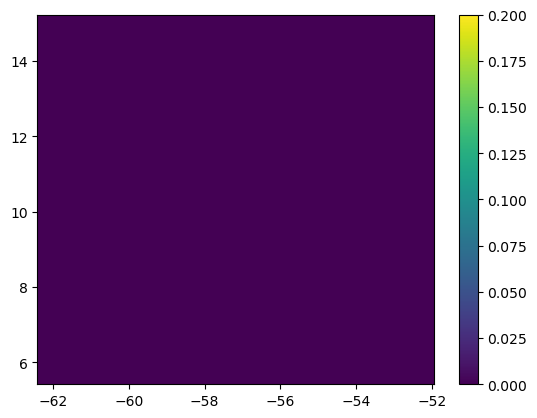

In [32]:
plt.pcolormesh(lon_M, lat_M, tot_rain[:,:], vmin=0., vmax=0.2)
plt.colorbar()

In [ ]:
'''# retrieve vapour pressure
QVAPOR = xr.open_dataset(wrf_files[files_ls.index('QVAPOR.nc')])
QVAPOR = QVAPOR['QVAPOR'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
QVAPOR = QVAPOR.where(sea_mask, drop=False)

vap_pres = mpcalc.vapor_pressure(pres*units.hPa, QVAPOR*units('kg/kg')).to('hPa')
vap_pres = vap_pres.magnitude()   # in hPa

dry_pres = pres-vap_pres

del QVAPOR

# retrieve temperature
pot_temp = xr.open_dataset(wrf_files[files_ls.index('T.nc')])
pot_temp = pot_temp['T']
pot_temp = pot_temp.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

# full pot_temp field
# = T+T0 , T0 = 300
pot_temp = pot_temp + 300
temperature = pot_temp * ( pres / 1000. )**0.286
del pot_temp

# get dry air density
rho_dry = meteo.rhod(temperature, dry_pres)'''